In [1]:
from zipline import run_algorithm
from zipline.api import schedule_function, date_rules, time_rules
from zipline.api import order_target_percent, symbol, order, record, symbols
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from trading_calendars.exchange_calendar_binance import BinanceExchangeCalendar
import pandas as pd
from trading_calendars import get_calendar
import pyfolio as pf
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from collections import Counter

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\zipline\__init__.py:45: UserWarning: Found TradingCalendar instances after zipline import.
Zipline startup will be much slower until this is fixed!
  warnings.warn(


### A few things to note:
1) zipline enters the ordered stock and amount in the order book (order() function). After the handle_data() function has finished, zipline looks for any open orders and tries to fill them. If the trading volume is high enough for this stock, the order is executed after adding the *commission* and applying the *slippage model* which models the influence of your order on the stock price, so your algorithm will be charged more than just the stock price. 

2) Order execution - When your algorithm places an order on a given bar, the order begins filling until the next bar regardless of the slippage model used. This way, the backtester guards the algorithm against lookahead bias.

### The strategy:
1) The algorithm is trained with historical price data by looking at the price movement of a underlying in the last 10 mins, and learning if the price increased or decreased on the 11th min. Then the algorithm can predict whether or not price will increase based on how the price has performed in the last 10 mins. 

2) If all the classifiers agree on the same prediction we will either buy or sell the underlying and if there is no consensus, we do nothing. 

3) Finally, based on the voted prediction and the momentum of the moving averages, we buy or sell traget percent of the portfolio.

In [3]:
def initialize(context):
    context.udy = symbols("ETHBTC")

    context.historical_bars = 100
    context.feature_window = 10
    
    # Rebalance every day, 1 min after market open.
    schedule_function(execute_trade, date_rules.every_day(), time_rules.market_open(minutes=1))
    
    schedule_function(monthly_review, date_rules.week_start(), time_rules.market_open(minutes=1))

In [4]:
def execute_trade(context,data):
    """
    Execute orders according to our schedule_function. 
    """
    prices = data.history(assets = context.udy, bar_count = context.historical_bars, frequency='1m', fields='price')


    for udy in context.udy:   
        
        try:

            price_hist = data.history(udy, 'price', 20, '1m')
            ma1 = price_hist.mean()
            price_hist = data.history(udy, 'price', 100, '1m')
            ma2 = price_hist.mean()
            
            start_bar = context.feature_window
            price_list = prices[udy].tolist()
            
            X = [] # list of feature sets
            y = [] # list of labels, one for each feature set
            
            bar = start_bar
            
            # feature creation
            while bar < len(price_list)-1:
                try:

                    end_price = price_list[bar+1] # t+1's price'
                    begin_price = price_list[bar] # t's price
                    
                    pricing_list = []
                    xx = 0
                    for _ in range(context.feature_window):
                        price = price_list[bar-(context.feature_window-xx)]
                        pricing_list.append(price)
                        xx += 1
                    
                    # get the % change in min prices of last 10 mins
                    features = np.around(np.diff(pricing_list) / pricing_list[:-1] * 100.0, 1)
                    
                    # if t+1's price is more than t's price
                    # label = 1 (buy) else -1 (sell)
                    if end_price > begin_price:
                        label = 1
                    else:
                        label = -1

                    bar += 1
                    X.append(features)
                    y.append(label)
                    # print(features)

                except Exception as e:
                    bar += 1
                    print(('feature creation',str(e)))


#             clf1 = RandomForestClassifier()
            clf2 = LinearSVC()
            clf4 = LogisticRegression()

            # now we get the prices and features for the last 10 mins
            last_prices = price_list[-context.feature_window:]
            current_features = np.around(np.diff(last_prices) / last_prices[:-1] * 100.0, 1)

            X.append(current_features)
            X = np.array(X)
            X = preprocessing.scale(X)

            current_features = X[-1]
            X = X[:-1]

#             clf1.fit(X,y)
            clf2.fit(X,y)
            clf4.fit(X,y)

            p2 = clf2.predict(current_features.reshape(1, -1))[0]
            p4 = clf4.predict(current_features.reshape(1, -1))[0]

            # if all the classifiers agree on the same prediction we will either buy or sell
            # if there is no consensus, we do nothing 
            if Counter([p2,p4]).most_common(1)[0][1] >= 2:
                p = Counter([p2,p4]).most_common(1)[0][0]
           
            else:
                p = 0

            print(('ma1_d: ',ma1))
            print(('ma2_d :',ma2))
#             print(('p2 :',p2))
#             print(('p4 :',p4))
            print(('Prediction',p))

            # Based on the voted prediction and the momentum of the moving averages
            if p == 1 and ma1 > ma2:
                    order_target_percent(udy,0.10)
            elif p == -1 and ma1 < ma2:
                order_target_percent(udy,-0.10)

        except Exception as e:
            print(str(e))
                      
    record('ma1',ma1)
    record('ma2',ma2)
    record('Leverage',context.account.leverage)
    

def monthly_review(context, data):
    price_hist = data.history(context.udy, 'price', 20, '1m')
    ma1 = price_hist.mean()
    price_hist = data.history(context.udy, 'price', 100, '1m')
    ma2 = price_hist.mean()
    print(('ma1',str(ma1)))
    print(('ma2',str(ma2)))

In [6]:
# standard analysis provided by pyFolio

def analyze_py(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    fig = pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
    for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
    

In [7]:
# customized analysis

def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(411)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    ax = fig.add_subplot(412)
    ax.plot(perf['gross_leverage'], label = 'Exposure', linestyle='-', linewidth=1.0) 
    ax.legend()
    ax.grid(True)
 
    ax = fig.add_subplot(413)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    
    ax = fig.add_subplot(414)
    ax.plot(perf['max_drawdown'], label='max drawdown', linestyle='-.', linewidth=1.0)   
    ax.legend()
    ax.grid(True)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043730000000000074)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043710000000000075)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043690000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04367000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043650000000000085)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043630000000000085)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data con

('ma1_d: ', 0.04430000000000001)
('ma2_d :', 0.04378999999999999)
('Prediction', -1)
('ma1_d: ', 0.04425000000000001)
('ma2_d :', 0.04379999999999999)
('Prediction', -1)
('ma1_d: ', 0.04425000000000001)
('ma2_d :', 0.04380999999999999)
('Prediction', -1)
('ma1_d: ', 0.04425000000000001)
('ma2_d :', 0.04382999999999998)
('Prediction', -1)
('ma1_d: ', 0.04420000000000001)
('ma2_d :', 0.043849999999999986)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.043869999999999985)
('Prediction', -1)
('ma1_d: ', 0.04420000000000001)
('ma2_d :', 0.04388999999999999)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04390999999999999)
('Prediction', 1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04392999999999999)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04393999999999999)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04395999999999999)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04398)
('Predicti

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04447999999999998)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04448999999999998)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04449999999999998)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04450999999999998)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044519999999999976)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04452999999999998)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04453999999999997)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04454999999999997)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044559999999999975)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04456999999999997)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044579999999999974)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044589999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04477999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044789999999999955)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04479999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04479999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04479999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044809999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044809999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04481999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04482999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04482999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04482999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044839999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04416000000000001)
('Prediction', -1)
('ma1_d: ', 0.044850000000000015)
('ma2_d :', 0.044170000000000015)
('Prediction', -1)
('ma1_d: ', 0.04490000000000001)
('ma2_d :', 0.04418000000000001)
('Prediction', -1)
('ma1_d: ', 0.04495000000000001)
('ma2_d :', 0.044190000000000014)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04420000000000001)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04421000000000001)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04422000000000001)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04423000000000001)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04424)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044250000000000005)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04426)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044270000000000004)
('Prediction', -1)

('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04425999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.044249999999999984)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04423999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.044229999999999985)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04421999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.044209999999999985)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04419999999999999)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one clas

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.043850000000000014)
('ma2_d :', 0.04397)
('Prediction', -1)
('ma1_d: ', 0.04380000000000001)
('ma2_d :', 0.043960000000000006)
('Prediction', -1)
('ma1_d: ', 0.04375000000000001)
('ma2_d :', 0.04395000000000002)
('Prediction', 1)
('ma1_d: ', 0.04370000000000001)
('ma2_d :', 0.04394000000000002)
('Prediction', 0)
('ma1_d: ', 0.04365000000000001)
('ma2_d :', 0.0439300000000

('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04326000000000001)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04327000000000001)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.043280000000000006)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.04328000000000001)
('Prediction', -1)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04327000000000001)
('Prediction', -1)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04328000000000001)
('Prediction', -1)
('ma1_d: ', 0.043850000000000014)
('ma2_d :', 0.04328000000000001)
('Prediction', 1)
('ma1_d: ', 0.04380000000000001)
('ma2_d :', 0.04328000000000002)
('Prediction', -1)
('ma1_d: ', 0.04380000000000001)
('ma2_d :', 0.043290000000000016)
('Prediction', -1)
('ma1_d: ', 0.04380000000000001)
('ma2_d :', 0.04330000000000002)
('Prediction', -1)
('ma1_d: ', 0.04380000000000001)
('ma2_d :', 0.043310000000000015)
('Prediction', -1)
('ma1_d: ', 0.04380000000000001)
('ma2_d :', 0.043320000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04265000000000001)
('ma2_d :', 0.04222999999999995)
('Prediction', -1)
('ma1_d: ', 0.04270000000000001)
('ma2_d :', 0.042229999999999955)
('Prediction', -1)
('ma1_d: ', 0.04275000000000001)
('ma2_d :', 0.042229999999999955)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.042229999999999955)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04222999999999996)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04222999999999997)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04222999999999997)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04222999999999997)
('Prediction', 1)
('ma1_d: ', 0.04305000000000001)
('ma2_d :', 0.04222999999999998)
('Prediction', -1)
('ma1_d: ', 0.04305000000000001)
('ma2_d :', 0.04222999999999998)
('Prediction', -1)
('ma1_d: ', 0.04305000000000001)
('ma2_d :', 0.04222999999999998)
('Prediction', -1)
('ma1_d: ', 0.04305000000000001)
('ma2_d :', 0.0422399999999999

('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04285000000000005)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042850000000000055)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042850000000000055)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04285000000000006)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04285000000000006)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042850000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042850000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042850000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042850000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042850000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042850000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.0428500000

('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04245999999999998)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042459999999999984)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04246)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042459999999999984)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04246)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04246)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042460000000000005)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042460000000000005)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042460000000000005)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04246000000000001)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04246000000000001)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04246000000000001)
('Prediction', -1)
('ma1_d: ',

('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04299000000000006)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.044259999999999966)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.044279999999999965)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.044299999999999964)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.04431999999999996)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.044339999999999956)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.04435999999999996)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.04437999999999996)
('Prediction', -1)
('ma1_d: ', 0.04525000000000001)
('ma2_d :', 0.04439999999999996)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.04441999999999996)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.044439999999999966)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.044459999999999965)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.044

('ma1_d: ', 0.04540000000000001)
('ma2_d :', 0.04514999999999999)
('Prediction', -1)
('ma1_d: ', 0.04545000000000001)
('ma2_d :', 0.04515999999999999)
('Prediction', -1)
('ma1_d: ', 0.04550000000000001)
('ma2_d :', 0.045169999999999995)
('Prediction', -1)
('ma1_d: ', 0.045550000000000014)
('ma2_d :', 0.04518)
('Prediction', -1)
('ma1_d: ', 0.045600000000000016)
('ma2_d :', 0.045189999999999994)
('Prediction', -1)
('ma1_d: ', 0.04565000000000001)
('ma2_d :', 0.0452)
('Prediction', -1)
('ma1_d: ', 0.04570000000000001)
('ma2_d :', 0.04520999999999999)
('Prediction', -1)
('ma1_d: ', 0.04575000000000001)
('ma2_d :', 0.045219999999999996)
('Prediction', -1)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.045229999999999985)
('Prediction', -1)
('ma1_d: ', 0.045850000000000016)
('ma2_d :', 0.04523999999999999)
('Prediction', -1)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045249999999999985)
('Prediction', -1)
('ma1_d: ', 0.04595000000000001)
('ma2_d :', 0.04525999999999998)
('Prediction', 

('ma1_d: ', 0.04550000000000001)
('ma2_d :', 0.045899999999999934)
('Prediction', -1)
('ma1_d: ', 0.04545000000000001)
('ma2_d :', 0.04588999999999993)
('Prediction', -1)
('ma1_d: ', 0.04540000000000001)
('ma2_d :', 0.04587999999999993)
('Prediction', -1)
('ma1_d: ', 0.045350000000000015)
('ma2_d :', 0.045869999999999925)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.04585999999999992)
('Prediction', -1)
('ma1_d: ', 0.04525000000000001)
('ma2_d :', 0.045849999999999926)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.04583999999999992)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.04582999999999993)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04581999999999993)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.045809999999999934)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04579999999999993)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045789999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04420000000000001)
('ma2_d :', 0.04449999999999995)
('Prediction', -1)
('ma1_d: ', 0.04420000000000001)
('ma2_d :', 0.04449999999999995)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04449999999999995)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04450999999999995)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.044519999999999955)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.044519999999999955)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04451999999999996)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04451999999999996)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04451999999999996)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04451999999999996)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.04451999999999996)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.0445199999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04435000000000001)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04436)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04437)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044379999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044379999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044379999999999996)
('Prediction', -1)
('ma1_d: ', 0.04495000000000001)
('ma2_d :', 0.04436999999999999)
('Prediction', -1)
('ma1_d: ', 0.04495000000000001)
('ma2_d :', 0.04436999999999999)
('Prediction', -1)
('ma1_d: ', 0.04495000000000001)
('ma2_d :', 0.04436999999999999)
('Prediction', -1)
('ma1_d: ', 0.04490000000000001)
('ma2_d :', 0.04435999999999999)
('Prediction', -1)
('ma1_d: ', 0.044850000000000015)
('ma2_d :', 0.04435999999999998)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04435999999999998)
('Prediction', -1)


C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04432999999999995)
('Prediction', -1)
('ma1_d: ', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.044029999999999986)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999998)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04401999999999999)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04402999999999999)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.044029999999999986)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.044029999999999986)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.044029999999999986)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.044029999999999986)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04401999999999

('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044839999999999956)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04484999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044859999999999955)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044869999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04488999999999996)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data conta

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04595000000000001)
('ma2_d :', 0.04538999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045399999999999954)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04540999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04541999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045429999999999957)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04543999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045449999999999956)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04545999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045469999999999955)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045479999999999944)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04548999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.0454999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045529999999999946)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04553999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04554999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04555999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04556999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045579999999999954)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04558999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04559999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045609999999999956)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04561999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045629999999999955)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04563999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma2_d :', 0.04584999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045859999999999956)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04586999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04587999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04588999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04589999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045909999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04591999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045929999999999964)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04593999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045959999999999966)
('Prediction', -1)
('ma1_d: 

('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04598999999999997)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.044989999999999954)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.0449899

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045119999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.0451

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04513999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04513999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04512999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04511999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04511999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04511999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04510999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04509999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04508999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045079999999999947)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04506999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04506999999999995

('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04589999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045909999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04591999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045929999999999964)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04593999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045959999999999966)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04596999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04596999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04596999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04596999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045969999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999997)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999996)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', 0)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', 0)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', 0)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', 0)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', 0)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04590000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.0459000000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.04522999999999997)
('Prediction', 0)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.04522999999999997)
('Prediction', 1)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.04522999999999997)
('Prediction', -1)
('ma1_d: ', 0.04575000000000001)
('ma2_d :', 0.04521999999999997)
('Prediction', -1)
('ma1_d: ', 0.04575000000000001)
('ma2_d :', 0.045209999999999965)
('Prediction', -1)
('ma1_d: ', 0.04570000000000001)
('ma2_d :', 0.04519999999999996)
('Prediction', -1)
('ma1_d: ', 0.04565000000000001)
('ma2_d :', 0.04519999999999995)
('Prediction', 0)
('ma1_d: ', 0.045600000000000016)
('ma2_d :', 0.04519999999999995)
('Prediction', -1)
('ma1_d: ', 0.045600000000000016)
('ma2_d :', 0.04519999999999995)
('Prediction', -1)
('ma1_d: ', 0.045550000000000014)
('ma2_d :', 0.04519999999999995)
('Prediction', -1)
('ma1_d: ', 0.04550000000000001)
('ma2_d :', 0.04519999999999994)
('Prediction', -1)
('ma1_d: ', 0.04545000000000001)
('ma2_d :', 0.04519999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.045350000000000015)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04525000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045199999999999935)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045

('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999995)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999995)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999994)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999995)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04508999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.0450899

('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045029999999999945)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samp

('ma1_d: ', 0.04525000000000001)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04532999999999991)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045329999999999926)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04532999999

('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045369999999999966)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045379999999999955)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04538999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045399999999999954)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04540999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04541999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045429999999999957)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04543999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045449999999999956)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04545999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045469999999999955)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045479999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', -1)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction',

('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046029999999999974)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046029999999999974)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046029999999999974)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046029999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', -1)
('ma1_d: ', 0.046100000000000016)
('ma2_d :', 0.04601999999999996)
('Prediction', 0)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04602999999999995)
('Prediction', 0)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04603999999999995)
('Prediction', 0)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04603999999999995)
('Prediction', 0)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.046049999999999945)


('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.046239999999999906)
('Prediction', -1)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.046239999999999906)
('Prediction', -1)
('ma1_d: ', 0.04670000000000001)
('ma2_d :', 0.04623999999999992)
('Prediction', -1)
('ma1_d: ', 0.046750000000000014)
('ma2_d :', 0.04623999999999992)
('Prediction', -1)
('ma1_d: ', 0.046800000000000015)
('ma2_d :', 0.04623999999999992)
('Prediction', -1)
('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.04624999999999991)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04624999999999992)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04624999999999992)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04624999999999992)
('Prediction', -1)
('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.04623999999999993)
('Prediction', -1)
('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.04623999999999993)
('Prediction', -1)
('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.0462299999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.04622999999999999)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.04622)
('Prediction', -1)
('ma1_d: ', 0.046500000000000014)
('ma2_d :', 0.04621)
('Prediction', -1)
('ma1_d: ', 0.04645000000000001)
('ma2_d :', 0.046210000000000015)
('Prediction', -1)
('ma1_d: ', 0.04640000000000001)
('ma2_d :', 0.04621000000000002)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04621000000000003)
('Prediction', -1)
('ma1_d: ', 0.046300000000000015)
('ma2_d :', 0.04621000000000003)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.046100000000000016)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04621000000000004)
('Prediction', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621000000000004)
('Prediction', -1)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04622000000000003)
('Prediction', -1)
('ma1_d: ', 0.046100000000000016)
('ma2_d :', 0.04623000000000002)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04624000000000002)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04625)
('Predict

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045979999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.0459799

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04616000000000001)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04617)
('Prediction', 1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04617999999999999)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04618999999999999)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04619999999999999)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04620999999999999)
('Prediction', -1)
('ma1_d: ', 0.04640000000000001)
('ma2_d :', 0.04621999999999999)
('Prediction', -1)
('ma1_d: ', 0.04645000000000001)
('ma2_d :', 0.046229999999999986)
('Prediction', -1)
('ma1_d: ', 0.046500000000000014)
('ma2_d :', 0.046239999999999976)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.04624999999999997)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.04625999999999997)
('Prediction', -1)
('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.046269999999999964)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04670000000000001)
('ma2_d :', 0.046440000000000016)
('Prediction', 0)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.04644000000000003)
('Prediction', -1)
('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.04644000000000003)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.04644000000000004)
('Prediction', -1)
('ma1_d: ', 0.046500000000000014)
('ma2_d :', 0.04644000000000004)
('Prediction', -1)
('ma1_d: ', 0.04645000000000001)
('ma2_d :', 0.046440000000000044)
('Prediction', -1)
('ma1_d: ', 0.04640000000000001)
('ma2_d :', 0.046440000000000044)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.04644000000000006)
('Prediction', -1)
('ma1_d: ', 0.046300000000000015)
('ma2_d :', 0.04644000000000006)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.04644000000000006)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04644000000000006)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04644000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.046100000000000016)
('ma2_d :', 0.04639999999999996)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.046399999999999955)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04639999999999994)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.046399999999999934)
('Prediction', -1)
('ma1_d: ', 0.046300000000000015)
('ma2_d :', 0.04639999999999993)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.046399999999999914)
('Prediction', -1)
('ma1_d: ', 0.04640000000000001)
('ma2_d :', 0.04639999999999991)
('Prediction', -1)
('ma1_d: ', 0.04645000000000001)
('ma2_d :', 0.0463999999999999)
('Prediction', -1)
('ma1_d: ', 0.046500000000000014)
('ma2_d :', 0.04639999999999989)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.04640999999999988)
('Prediction', -1)
('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.04641999999999988)
('Prediction', -1)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.0464299999

('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04663000000000008)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04663000000000008)
('Prediction', -1)
('ma1_d: ', 0.046100000000000016)
('ma2_d :', 0.04663000000000008)
('Prediction', -1)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04663000000000008)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046630000000000074)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046630000000000074)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04663000000000007)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04663000000000007)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04663000000000007)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04663000000000005)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04663000000000005)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04663000000000

('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.046930000000000055)
('Prediction', -1)
('ma1_d: ', 0.04790000000000001)
('ma2_d :', 0.046950000000000054)
('Prediction', -1)
('ma1_d: ', 0.04795000000000001)
('ma2_d :', 0.04697000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04699000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04701000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.047030000000000044)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04705000000000004)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04707000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04709000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04711000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04713000000000005)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.047150

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04830000000000002)
('ma2_d :', 0.04814000000000003)
('Prediction', -1)
('ma1_d: ', 0.048250000000000015)
('ma2_d :', 0.04814000000000003)
('Prediction', -1)
('ma1_d: ', 0.048200000000000014)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.04815000000000001)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.04810000000000002)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048050000000000016)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048050000000000016)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.048140000000000016)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.

('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', 0)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', 0)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', 0)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047970000000000027)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.0479700000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04770000000000001)
('ma2_d :', 0.04734000000000002)
('Prediction', -1)
('ma1_d: ', 0.047750000000000015)
('ma2_d :', 0.047350000000000024)
('Prediction', -1)
('ma1_d: ', 0.047750000000000015)
('ma2_d :', 0.04736000000000003)
('Prediction', -1)
('ma1_d: ', 0.047750000000000015)
('ma2_d :', 0.04737000000000003)
('Prediction', -1)
('ma1_d: ', 0.047750000000000015)
('ma2_d :', 0.04738000000000003)
('Prediction', -1)
('ma1_d: ', 0.047800000000000016)
('ma2_d :', 0.047390000000000036)
('Prediction', -1)
('ma1_d: ', 0.04785000000000002)
('ma2_d :', 0.047400000000000025)
('Prediction', -1)
('ma1_d: ', 0.04790000000000001)
('ma2_d :', 0.047410000000000035)
('Prediction', -1)
('ma1_d: ', 0.04795000000000001)
('ma2_d :', 0.047420000000000025)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04743000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.047440000000000024)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.0474

('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.047950000000000034)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795000000000003)
('Prediction', -1)
('ma1_d: ', 0.048000000000000015)
('ma2_d :', 0.04795

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.047750000000000015)
('ma2_d :', 0.04792000000000002)
('Prediction', 0)
('ma1_d: ', 0.04770000000000001)
('ma2_d :', 0.047910000000000015)
('Prediction', -1)
('ma1_d: ', 0.04765000000000001)
('ma2_d :', 0.04790000000000001)
('Prediction', -1)
('ma1_d: ', 0.04760000000000002)
('ma2_d :', 0.04789000000000001)
('Prediction', -1)
('ma1_d: ', 0.047550000000000016)
('ma2_d :', 0.047880000000000006)
('Prediction', -1)
('ma1_d: ', 0.047500000000000014)
('ma2_d :', 0.047869999999999996)
('Prediction', -1)
('ma1_d: ', 0.04745000000000001)
('ma2_d :', 0.04785999999999999)
('Prediction', -1)
('ma1_d: ', 0.04740000000000001)
('ma2_d :', 0.04784999999999999)
('Prediction', -1)
('ma1_d: ', 0.04735000000000002)
('ma2_d :', 0.04783999999999999)
('Prediction', -1)
('ma1_d: ', 0.047300000000000016)
('ma2_d :', 0.04783)
('Prediction', -1)
('ma1_d: ', 0.047250000000000014)
('ma2_d :', 0.047819999999999994)
('Prediction', -1)
('ma1_d: ', 0.04720000000000001)
('ma2_d :', 0.04780999999999999)
('P

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04763)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.047619999999999996)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04761)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.047599999999999996)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04759)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04758)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04757000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04756000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04755000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04754000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04753000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.047520000000000014)
('Prediction', -1)
('ma1_d: ', 0

('ma1_d: ', 0.04575000000000001)
('ma2_d :', 0.04616999999999996)
('Prediction', -1)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.04615999999999997)
('Prediction', -1)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.04614999999999997)
('Prediction', -1)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.04613999999999997)
('Prediction', -1)
('ma1_d: ', 0.045850000000000016)
('ma2_d :', 0.04612999999999997)
('Prediction', -1)
('ma1_d: ', 0.045850000000000016)
('ma2_d :', 0.04610999999999997)
('Prediction', -1)
('ma1_d: ', 0.045850000000000016)
('ma2_d :', 0.04608999999999997)
('Prediction', -1)
('ma1_d: ', 0.045800000000000014)
('ma2_d :', 0.046069999999999965)
('Prediction', -1)
('ma1_d: ', 0.04575000000000001)
('ma2_d :', 0.046049999999999966)
('Prediction', -1)
('ma1_d: ', 0.04570000000000001)
('ma2_d :', 0.04602999999999996)
('Prediction', -1)
('ma1_d: ', 0.04565000000000001)
('ma2_d :', 0.04600999999999997)
('Prediction', -1)
('ma1_d: ', 0.045600000000000016)
('ma2_d :', 0.04598999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.045050000000000014)
('ma2_d :', 0.04506999999999995)
('Prediction', -1)
('ma1_d: ', 0.045100000000000015)
('ma2_d :', 0.04507999999999995)
('Prediction', -1)
('ma1_d: ', 0.04515000000000001)
('ma2_d :', 0.045089999999999957)
('Prediction', -1)
('ma1_d: ', 0.04520000000000001)
('ma2_d :', 0.04509999999999996)
('Prediction', -1)
('ma1_d: ', 0.04525000000000001)
('ma2_d :', 0.04510999999999996)
('Prediction', -1)
('ma1_d: ', 0.045300000000000014)
('ma2_d :', 0.045119999999999966)
('Prediction', -1)
('ma1_d: ', 0.045350000000000015)
('ma2_d :', 0.045129999999999976)
('Prediction', -1)
('ma1_d: ', 0.04540000000000001)
('ma2_d :', 0.04513999999999998)
('Prediction', -1)
('ma1_d: ', 0.04545000000000001)
('ma2_d :', 0.04514999999999999)
('Prediction', -1)
('ma1_d: ', 0.04550000000000001)
('ma2_d :', 0.04515999999999999)
('Prediction', -1)
('ma1_d: ', 0.045550000000000014)
('ma2_d :', 0.045169999999999995)
('Prediction', -1)
('ma1_d: ', 0.045600000000000016)
('ma2_d :', 0.04518)
(

('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04545999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045449999999999956)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04543999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04542999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04541999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04540999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04539999999999997)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04538999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045379999999999955)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045369999999999966)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04535999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.045349999999999

('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04584999999999998)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04585999999999998)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04586999999999998)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.045879999999999976)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04588999999999998)
('Prediction', -1)
('ma1_d: ', 0.046100000000000016)
('ma2_d :', 0.04589999999999998)
('Prediction', -1)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04590999999999998)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04591999999999998)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045929999999999985)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.045939999999999974)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04594999999999998)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.0459599999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', -1)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0.046050000000000015)
('ma2_d :', 0.04600999999999997)
('Prediction', 0)
('ma1_d: ', 0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046399999999999976)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04640999999999998)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04641999999999999)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04642999999999999)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046439999999999995)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04645)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04646)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046470000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04648000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04649000000000001)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046500000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.0465100

('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04666999999999998)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04666999999999998)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04666999999999997)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04666999999999997)
('Prediction', -1)
('ma1_d: ', 0.04695000000000001)
('ma2_d :', 0.046659999999999986)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04664999999999999)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04664999999999999)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04664999999999999)
('Prediction', -1)
('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.04664000000000001)
('Prediction', -1)
('ma1_d: ', 0.046800000000000015)
('ma2_d :', 0.04663000000000001)
('Prediction', -1)
('ma1_d: ', 0.046750000000000014)
('ma2_d :', 0.04663000000000002)
('Prediction', -1)
('ma1_d: ', 0.04670000000000001)
('ma2_d :', 0.04663000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.04691000000000003)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04691000000000003)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04691000000000003)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04691000000000003)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04691000000000003)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04691000000000003)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction',

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046910000000000014)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.046990000000000004)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :

('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.04652999999999993)
('Prediction', -1)
('ma1_d: ', 0.046800000000000015)
('ma2_d :', 0.046519999999999936)
('Prediction', -1)
('ma1_d: ', 0.046800000000000015)
('ma2_d :', 0.04651999999999995)
('Prediction', -1)
('ma1_d: ', 0.046750000000000014)
('ma2_d :', 0.046509999999999954)
('Prediction', -1)
('ma1_d: ', 0.046750000000000014)
('ma2_d :', 0.046509999999999954)
('Prediction', -1)
('ma1_d: ', 0.04670000000000001)
('ma2_d :', 0.04649999999999996)
('Prediction', -1)
('ma1_d: ', 0.04670000000000001)
('ma2_d :', 0.046499999999999965)
('Prediction', -1)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.046489999999999976)
('Prediction', -1)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.04648999999999998)
('Prediction', -1)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.04648999999999998)
('Prediction', -1)
('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.04647999999999999)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.0464699

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma1_d: ', 0.04640000000000001)
('ma2_d :', 0.04644)
('Prediction', -1)
('ma1_d: ', 0.046350000000000016)
('ma2_d :', 0.046430000000000006)
('Prediction', -1)
('ma1_d: ', 0.046300000000000015)
('ma2_d :', 0.04642000000000001)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.04641000000000002)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.046400000000000025)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.04639000000000002)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.046380000000000025)
('Prediction', -1)
('ma1_d: ', 0.04625000000000001)
('ma2_d :', 0.04637000000000002)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.04636000000000004)
('Prediction', -1)
('ma1_d: ', 0.04620000000000001)
('ma2_d :', 0.046350000000000044)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.046350000000000044)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.046350000000000044)
('

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046250000000000006)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04625)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04625)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04624999999999999)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04624999999999999)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046249999999999986)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046249999999999986)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04624999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04624999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046249999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046249999999999965)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046249999999999965)
('Prediction', -1

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.04621999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04621999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046209999999999966)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04619999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04618999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04617999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04616999999999996)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04615999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04614999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04613999999999997)
('Prediction', -1)
('ma1_d: ',

('ma1_d: ', 0.04645000000000001)
('ma2_d :', 0.04608999999999992)
('Prediction', 0)
('ma1_d: ', 0.046500000000000014)
('ma2_d :', 0.04609999999999991)
('Prediction', -1)
('ma1_d: ', 0.046550000000000015)
('ma2_d :', 0.04610999999999991)
('Prediction', -1)
('ma1_d: ', 0.046600000000000016)
('ma2_d :', 0.046119999999999904)
('Prediction', -1)
('ma1_d: ', 0.04665000000000001)
('ma2_d :', 0.0461299999999999)
('Prediction', -1)
('ma1_d: ', 0.04670000000000001)
('ma2_d :', 0.04613999999999989)
('Prediction', -1)
('ma1_d: ', 0.046750000000000014)
('ma2_d :', 0.04614999999999989)
('Prediction', -1)
('ma1_d: ', 0.046800000000000015)
('ma2_d :', 0.046159999999999896)
('Prediction', -1)
('ma1_d: ', 0.04685000000000002)
('ma2_d :', 0.046169999999999906)
('Prediction', -1)
('ma1_d: ', 0.04690000000000001)
('ma2_d :', 0.04617999999999991)
('Prediction', -1)
('ma1_d: ', 0.04695000000000001)
('ma2_d :', 0.04618999999999991)
('Prediction', -1)
('ma1_d: ', 0.047000000000000014)
('ma2_d :', 0.04619999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04643999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04643999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04643999999999997)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046439999999999954)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046439999999999954)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046439999999999954)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04643999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046429999999999944)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04641999999999995)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.046409999999999944)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.04639999999999994)
('Prediction', -1)
('ma1_d: ', 0.04600000000000001)
('ma2_d :', 0.0463899999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999997)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999998)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.04607999999999999)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.046079999999999996)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.046079999999999996)
('Prediction', -1)
('ma1_d: ', 0.04615000000000001)
('ma2_d :', 0.0460799999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04450000000000001)
('ma2_d :', 0.04489999999999992)
('Prediction', -1)
('ma1_d: ', 0.04445000000000001)
('ma2_d :', 0.044889999999999916)
('Prediction', -1)
('ma1_d: ', 0.04440000000000001)
('ma2_d :', 0.04487999999999991)
('Prediction', -1)
('ma1_d: ', 0.044350000000000014)
('ma2_d :', 0.044869999999999924)
('Prediction', -1)
('ma1_d: ', 0.04430000000000001)
('ma2_d :', 0.04485999999999992)
('Prediction', -1)
('ma1_d: ', 0.04425000000000001)
('ma2_d :', 0.044849999999999925)
('Prediction', 1)
('ma1_d: ', 0.04420000000000001)
('ma2_d :', 0.04483999999999993)
('Prediction', -1)
('ma1_d: ', 0.04415000000000001)
('ma2_d :', 0.044829999999999925)
('Prediction', -1)
('ma1_d: ', 0.044100000000000014)
('ma2_d :', 0.04481999999999993)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.044809999999999926)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.04479999999999992)
('Prediction', -1)
('ma1_d: ', 0.04405000000000001)
('ma2_d :', 0.044789999999

('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04417000000000001)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04418000000000001)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.044190000000000014)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04420000000000001)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04421000000000001)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04422000000000001)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04423000000000001)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.04424)
('Prediction', -1)
('ma1_d: ', 0.04480000000000001)
('ma2_d :', 0.044250000000000005)
('Prediction', -1)
('ma1_d: ', 0.044850000000000015)
('ma2_d :', 0.04426)
('Prediction', -1)
('ma1_d: ', 0.04490000000000001)
('ma2_d :', 0.044270000000000004)
('Prediction', -1)
('ma1_d: ', 0.04495000000000001)
('ma2_d :', 0.04428)
('Prediction', -1)
('ma1_d: ', 

('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04487999999999995)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04488999999999996)
('Prediction', -1)
('ma1_d: ', 0.04500000000000001)
('ma2_d :', 0.04489999999999995)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04336000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04335000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04334000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04333000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04332000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04331000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043300000000000075)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04329000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04328000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04327000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04326000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04325000000000006

('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.04322000000000001)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.043230000000000005)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.04324000000000001)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.043250000000000004)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.04326000000000001)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.04327)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.043280000000000006)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.043289999999999995)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.0433)
('Prediction', -1)
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.0433)
('Prediction', -1)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04330000000000001)
('Prediction', -1)
('ma1_d: ', 0.043850000000000014)
('ma2_d :', 0.04330000000000001)
('Prediction', -1)
('ma1_d: ', 0

('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04384)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.043849999999999986)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04385999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04386999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04386999999999999)
('Prediction', -1)
('ma1_d: ', 0.04400000000000001)
('ma2_d :', 0.04387999999999999)
('Predict

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04395000000000001)
('ma2_d :', 0.043989999999999994)
('Prediction', 0)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04398)
('Prediction', 0)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04398)
('Prediction', 1)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04398)
('Prediction', 0)
('ma1_d: ', 0.04390000000000001)
('ma2_d :', 0.04398)
('Prediction', -1)
('ma1_d: ', 0.

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04364000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043630000000000065)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043620000000000075)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043610000000000065)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043600000000000076)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04359000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04358000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043570000000000074)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04356000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043550000000000075)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04354000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043530000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', 0)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', 0)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000006)
('Prediction', 0)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000006)
('Prediction', 0)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', 0)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('m

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04305000000000001)
('ma2_d :', 0.043010000000000055)
('Prediction', 

('ma1_d: ', 0.04340000000000001)
('ma2_d :', 0.04330000000000003)
('Prediction', -1)
('ma1_d: ', 0.043350000000000014)
('ma2_d :', 0.04330000000000003)
('Prediction', -1)
('ma1_d: ', 0.04330000000000001)
('ma2_d :', 0.04330000000000003)
('Prediction', -1)
('ma1_d: ', 0.04325000000000001)
('ma2_d :', 0.04330000000000003)
('Prediction', -1)
('ma1_d: ', 0.04320000000000001)
('ma2_d :', 0.04330000000000003)
('Prediction', -1)
('ma1_d: ', 0.04315000000000001)
('ma2_d :', 0.043290000000000044)
('Prediction', -1)
('ma1_d: ', 0.04310000000000001)
('ma2_d :', 0.04328000000000004)
('Prediction', -1)
('ma1_d: ', 0.04305000000000001)
('ma2_d :', 0.043270000000000045)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04326000000000004)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.043250000000000045)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04324000000000004)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04323000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04298000000000006)

('ma1_d: ', 0.04275000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04262999999999999)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04262999999999998)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04262999999999998)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04262999999999998)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04262999999999998)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.04230999999999992)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04230999999999992)
('Prediction', -1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.04230999999999993)
('Prediction', -1)
('ma1_d: ', 0.04225000000000001)
('ma2_d :', 0.04230999999999993)
('Prediction', -1)
('ma1_d: ', 0.04230000000000001)
('ma2_d :', 0.04230999999999993)
('Prediction', -1)
('ma1_d: ', 0.04235000000000001)
('ma2_d :', 0.04230999999999994)
('Prediction', -1)
('ma1_d: ', 0.04240000000000001)
('ma2_d :', 0.04231999999999994)
('Prediction', -1)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.04231999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04231999999999995)
('Prediction', -1)
('ma1_d: ', 0.04255000000000001)
('ma2_d :', 0.04231999999999995)
('Prediction', -1)
('ma1_d: ', 0.04260000000000001)
('ma2_d :', 0.04231999999999995)
('Prediction', -1)
('ma1_d: ', 0.04265000000000001)
('ma2_d :', 0.042319999999999955

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04260000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04260000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04255000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', 1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04240000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04235000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04230000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04230000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04225000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.04211999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0421199

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999956)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.04212999999999996)
('Prediction', -1)
('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.04213999999999995)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04214999999999995)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04214999999999995)
('Prediction', -1)
('ma

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04225000000000001)
('ma2_d :', 0.04216999999999995)
('Prediction', -1)
('ma1_d: ', 0.04230000000000001)
('ma2_d :', 0.04217999999999995)
('Prediction', -1)
('ma1_d: ', 0.04235000000000001)
('ma2_d :', 0.04218999999999995)
('Prediction', -1)
('ma1_d: ', 0.04240000000000001)
('ma2_d :', 0.042199999999999946)
('Prediction', -1)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.04220999999999995)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04221999999999995)
('Prediction', -1)
('ma1_d: ', 0.04255000000000001)
('ma2_d :', 0.04222999999999995)
('Prediction', -1)
('ma1_d: ', 0.04260000000000001)
('ma2_d :', 0.04223999999999995)
('Prediction', -1)
('ma1_d: ', 0.04265000000000001)
('ma2_d :', 0.042249999999999954)
('Prediction', -1)
('ma1_d: ', 0.04270000000000001)
('ma2_d :', 0.04225999999999996)
('Prediction', -1)
('ma1_d: ', 0.04275000000000001)
('ma2_d :', 0.04226999999999996)
('Prediction', -1)


C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04227999999999996)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04228999999999996)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04229999999999996)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042309999999999966)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04231999999999997)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04232999999999997)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042339999999999975)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04234999999999998)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04235999999999998)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042369999999999984)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04237999999999999)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042389999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.04254000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04255000000000005)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042560000000000056)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04257000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04258000000000006)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042590000000000065)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04259000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04259000000000007)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042590000000000086)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042590000000000086)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042590000000000086)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042590000000000086)
('Prediction', -1)
('ma1_

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04260000000000009)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04260000000000009)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04261000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04261000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04262000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04263000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04264000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04265000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04265000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04265000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04265000000000008)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04266000000000007)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.04251999999999991)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.04250999999999991)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.0424999999999999)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.042489999999999896)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.04247999999999989)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.04246999999999989)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.0424599999999999)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.0424499999999999)
('Prediction', -1)
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.0424399999999999)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0424299999999999)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0424199999999999)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0424099999999999)
('Pre

('ma1_d: ', 0.04235000000000001)
('ma2_d :', 0.042069999999999934)
('Prediction', 0)
('ma1_d: ', 0.04240000000000001)
('ma2_d :', 0.04207999999999994)
('Prediction', 0)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.04208999999999994)
('Prediction', 0)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.04208999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04209999999999994)
(

('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.042179999999999974)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04218999999999998)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04219999999999998)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.042209999999999984)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04221999999999999)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04222999999999999)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04223999999999999)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042249999999999996)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.042249999999999996)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04226)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04226)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04227)
('Prediction', 0)
('ma1_d: ', 0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042119999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04210999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04209999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04208999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.042079999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04206999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04205999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04204999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04203999999999992)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.042009999999999915)
('Prediction', -1)
('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.04201999999999992)
('Prediction', -1)
('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.04201999999999992)
('Prediction', 0)
('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.04201999999999992)
('Prediction', 0)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04202999999999992)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04202999999999992)
('Prediction', 0)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04202999999999992)
('Prediction', 0)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04202999999999992)
('Prediction', -1)
('ma1_d: ', 0.042

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04205000000000001)
('ma2_d :', 0.042009999999999915)
('Prediction', -1)
('ma1_d: ', 0.04210000000000001)
('ma2_d :', 0.04201999999999992)
('Prediction', -1)
('ma1_d: ', 0.04215000000000001)
('ma2_d :', 0.04202999999999992)
('Prediction', 0)
('ma1_d: ', 0.04220000000000001

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04225000000000001)
('ma2_d :', 0.04285000000000002)
('Prediction', -1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.04284000000000002)
('Prediction', -1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.04284000000000002)
('Prediction', 1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.04284000000000002)
('Prediction', -1)
('ma1_d: ', 0.04220000000000001)
('ma2_d :', 0.04284000000000002)
('Prediction', -1)
('ma1_d: ', 0.04225000000000001)
('ma2_d :', 0.04284000000000002)
('Prediction', -1)
('ma1_d: ', 0.04230000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04270000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04275000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04290000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04295000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04284000000000001)
('Prediction', -1)
('ma1_d: ', 0.04300000000000001)
('ma2_d :', 0.04284000000000001)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04285000000000001)
('ma2_d :', 0.04281000000000007)
('Prediction', -1)
('ma1_d: ', 0.04280000000000001)
('ma2_d :', 0.04280000000000007)
('Prediction', -1)
('ma1_d: ', 0.04275000000000001)
('ma2_d :', 0.042790000000000064)
('Prediction', -1)
('ma1_d: ', 0.04270000000000001)
('ma2_d :', 0.04278000000000006)
('Prediction', -1)
('ma1_d: ', 0.04265000000000001)
('ma2_d :', 0.04277000000000006)
('Prediction', -1)
('ma1_d: ', 0.04260000000000001)
('ma2_d :', 0.04276000000000005)
('Prediction', -1)
('ma1_d: ', 0.04255000000000001)
('ma2_d :', 0.042750000000000045)
('Prediction', -1)
('ma1_d: ', 0.04250000000000001)
('ma2_d :', 0.04274000000000004)
('Prediction', -1)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.04273000000000004)
('Prediction', -1)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.042720000000000036)
('Prediction', -1)
('ma1_d: ', 0.04245000000000001)
('ma2_d :', 0.04271000000000003)
('Prediction', -1)
('ma1_d: ', 0.04240000000000001)
('ma2_d :', 0.042700000000000

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04241999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04240999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04239999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0423999999999999)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0423999999999999)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but th

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.041879999999999945)
('Prediction', 0)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04186999999999995)
('Prediction', -1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.041859999999999946)
('Prediction', -1)
('ma1_d: ', 0.04125000000000001)
('ma2_d :', 0.04184999999999995)
('Prediction', -1)
('ma1_d: ', 0.04125000000000001)
('ma2_d :', 0.04184999999999994)
('Prediction', -1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.04184999999999994)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.041849999999999936)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04183999999999994)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.041829999999999944)
('Prediction', -1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.04181999999999995)
('Prediction', 0)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.04181999999999995)
('Prediction', -1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.041809999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.04180999999999994)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.04180999999999994)
('Prediction', -1)
('ma1_d: ', 0.04150000000000001)
('ma2_d :', 0.04180999999999994)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04180999999999994)
('Prediction', 1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04179999999999994)
('Prediction', -1)
('ma1_d: ', 0.04160000000000001)
('ma2_d :', 0.04179999999999994)
('Prediction', 1)
('ma1_d: ', 0.04160000000000001)
('ma2_d :', 0.04178999999999995)
('Prediction', -1)
('ma1_d: ', 0.04160000000000001)
('ma2_d :', 0.041779999999999956)
('Prediction', -1)
('ma1_d: ', 0.04160000000000001)
('ma2_d :', 0.04176999999999995)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04175999999999996)
('Prediction', -1)
('ma1_d: ', 0.04150000000000001)
('ma2_d :', 0.04174999999999996)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.04173999999999996)

('ma1_d: ', 0.04120000000000001)
('ma2_d :', 0.04124999999999995)
('Prediction', -1)
('ma1_d: ', 0.04125000000000001)
('ma2_d :', 0.041259999999999956)
('Prediction', -1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.04126999999999995)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04127999999999995)
('Prediction', -1)
('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.04128999999999995)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.041299999999999955)
('Prediction', -1)
('ma1_d: ', 0.04150000000000001)
('ma2_d :', 0.04130999999999995)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.041319999999999954)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04131999999999996)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04131999999999997)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04131999999999997)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04132999999999

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04182999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04182999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04183999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041849999999999915)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04185999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04185999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.04185999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04185999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04185999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041869999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04187999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04188999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041899999999999916)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples o

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04190999999999995)
('Prediction', 1)
('ma1_d: ', 0.04150000000000001)
('ma2_d :', 0.041899999999999944)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.04188999999999995)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.04188999999999994)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.04188999999999994)
('Prediction', -1)
('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.04187999999999994)
('Prediction', 0)
('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.04187999999999994)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04186999999999994)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04186999999999994)
('Prediction', 1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.04185999999999994)
('Prediction', -1)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.04185999999999994)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04185999999999994)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.041829999999999944)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.041829999999999944)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04181999999999995)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.041809999999999944)
('Prediction', -1)
('ma1_d: ', 0.04170000000000001)
('ma2_d :', 0.041799999999999955)
('Prediction', -1)
('ma1_d: ', 0.041650000000000006)
('ma2_d :', 0.04178999999999996)
('Prediction', -1)
('ma1_d: ', 0.04160000000000001)
('ma2_d :', 0.041779999999999956)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04176999999999996)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04175999999999996)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04175999999999996)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04175999999999995)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.041759999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.041759999999999936)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.041759999999999936)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.041759999999999936)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04175999999999993)
('Prediction', -1)
('ma1_d: ', 0.04155000000000001)
('ma2_d :', 0.04175999999999993)
('Prediction', -1)
('ma1_d: ', 0.04160000000000001)
('ma2_d :', 0.04175999999999993)
('Prediction', -1)
('ma1_d: ', 0.041650000000000006)
('ma2_d :', 0.04175999999999993)
('Prediction', -1)
('ma1_d: ', 0.041650000000000006)
('ma2_d :', 0.04175999999999993)
('Prediction', -1)
('ma1_d: ', 0.04170000000000001)
('ma2_d :', 0.04175999999999992)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.04175999999999992)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04175999999999992)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.0417599999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.04181999999999993)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04175000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04180000000000002)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.0418399999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04101999999999996

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.041009999999999956)
('Prediction', 0)
('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.04101999999999995)
('Prediction', -1)
('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.04101999999999995)
('Prediction', 0)
('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.04101999999999996)
('Prediction', 0)
('ma1_d: ', 0.041150000000000006)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04120000000000001)
('ma2_d :', 0.041039999999999945)
('Prediction', 0)
('ma1_d: ', 0.04125000000000001)
('ma2_d :', 0.04104999999999994)
('Prediction', 0)
('ma1_d: ', 0.04130000000000001)
('ma2_d :', 0.041059999999999944)
('Prediction', 0)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04106999999999994)
('Prediction', 0)
('ma1_d: ', 0.041400000000000006)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04111999999999995)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04150000000000001)
('ma2_d :', 0.041439999999999914)
('Prediction', -1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.041439999999999914)
('Prediction', -1)
('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.04143999999999992)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04143999999999993)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.041449999999999924)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04145999999999992)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04146999999999992)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04147999999999992)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04147999999999992)
('Prediction', -1)
('ma1_d: ', 0.04135000000000001)
('ma2_d :', 0.04148999999999992)
('Prediction', -1)
('ma1_d: ', 0.041400000000000006)
('ma2_d :', 0.041499999999999926)
('Prediction', 1)
('ma1_d: ', 0.04145000000000001)
('ma2_d :', 0.0415099999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.041150000000000006)
('ma2_d :', 0.04126999999999997)
('Prediction', -1)
('ma1_d: ', 0.041150000000000006)
('ma2_d :', 0.04125999999999997)
('Prediction', -1)
('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.04124999999999997)
('Prediction', -1)
('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.041239999999999964)
('Prediction', -1)
('ma1_d: ', 0.04110000000000001)
('ma2_d :', 0.04122999999999996)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04121999999999995)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04120999999999996)
('Prediction', -1)
('ma1_d: ', 0.04105000000000001)
('ma2_d :', 0.04119999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041189999999999956)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04117999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04116999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041159999999999954)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04114999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04114999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04114999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04114999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04113999999999995

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04110999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041099999999999956)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04108999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041079999999999964)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04106999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.0410599999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.0410599

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.041689999999999915)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.04168999999999992)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.04169999999999993)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04169999999999993)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.041709999999999935)
('Prediction', 1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.041719999999999924)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04172999999999993)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04173999999999992)
('Prediction', 1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.041749999999999926)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04175999999999992)
('Prediction', 1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.041769999999999925)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.0417799999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.041809999999999924)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.04181999999999993)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.041829999999999916)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04183999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04184999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04185999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04186999999999992)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.04187999999999992)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.04188999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04189999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04190999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0419199999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041949999999999925)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0419599

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0419599

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04195999999999991

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0419599

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041959999999999914)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041969999999999924)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data co

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041589999999999974)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04157999999999998)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041569999999999975)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04155999999999998)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041549999999999976)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04153999999999998)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04152999999999998)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04151999999999998)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04150999999999998)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04149999999999999)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041489999999999985)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04147999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.0414999999999999)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.0415099999999999)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.041519999999999904)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.0415299999999999)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04152999999999991)
('Prediction', 0)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04153999999999991)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04154999999999991)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04155999999999991)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.041569999999999906)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04157999999999991)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04158999999999991)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.0415999999999999)
('

('ma2_d :', 0.04177999999999992)
('Prediction', -1)
('ma1_d: ', 0.04180000000000001)
('ma2_d :', 0.04177999999999992)
('Prediction', -1)
('ma1_d: ', 0.04185000000000001)
('ma2_d :', 0.04177999999999992)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04177999999999991)
('Prediction', -1)
('ma1_d: ', 0.04190000000000001)
('ma2_d :', 0.04177999999999991)
('Prediction', -1)
('ma1_d: ', 0.04195000000000001)
('ma2_d :', 0.04177999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04177999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04177999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04178999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04178999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04178999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04178999999999991)
('Prediction', -1)
('ma1_d: ', 0

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04185999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04186999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04187999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04188999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04189999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04190999999999991)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041919999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041919999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041919999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041919999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041919999999999916)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.0419199999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04192999999999992)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', 0)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', 0)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', 0)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', 0)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', 0)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', -1)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', -1)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04098999999999996)
('Prediction', -1)
('ma1_d: ', 0.040900000000000006)
('ma2_d :', 0.040979999999999954)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04096999999999995)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04096999999999995)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04096999999999996)
('

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04005000000000001)
('ma2_d :', 0.04077999999999997)
('Prediction', -1)
('ma1_d: ', 0.04005000000000001)
('ma2_d :', 0.04076999999999997)
('Prediction', -1)
('ma1_d: ', 0.04005000000000001)
('ma2_d :', 0.04075999999999997)
('Prediction', -1)
('ma1_d: ', 0.04005000000000001)
('ma2_d :', 0.040749999999999974)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04073999999999997)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040729999999999975)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04071999999999997)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04070999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04069999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04068999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04067999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.0406699999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04080000000000001)
('ma2_d :', 0.04016000000000001)
('Prediction', -1)
('ma1_d: ', 0.04080000000000001)
('ma2_d :', 0.04017000000000001)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04018000000000001)
('Prediction', -1)
('ma1_d: ', 0.040900000000000006)
('ma2_d :', 0.04019000000000001)
('Prediction', -1)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04020000000000001)
('Prediction', -1)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04021000000000001)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040220000000000006)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04023000000000001)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04024)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04025)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04026)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04027)
('Prediction', -1)
('ma1_d: ', 0.041000000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04067999999999996)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04068999999999996)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.040699999999999965)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04070999999999996)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.040719999999999965)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04072999999999997)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.040739999999999964)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04074999999999997)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04075999999999996)
('Prediction', -1)
('ma1_d: ', 0.04060000000000001)
('ma2_d :', 0.040769999999999966)
('Prediction', -1)
('ma1_d: ', 0.040650000000000006)
('ma2_d :', 0.04077999999999997)
('Prediction', -1)
('ma1_d: ', 0.04070000000000001)
('ma2_d :', 0.0407899999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.040400000000000005)
('ma2_d :', 0.040879999999999965)
('Prediction', -1)
('ma1_d: ', 0.040400000000000005)
('ma2_d :', 0.040879999999999965)
('Prediction', -1)
('ma1_d: ', 0.040400000000000005)
('ma2_d :', 0.04087999999999997)
('Prediction', -1)
('ma1_d: ', 0.040400000000000005)
('ma2_d :', 0.04087999999999997)
('Prediction', -1)
('ma1_d: ', 0.04035000000000001)
('ma2_d :

('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04004000000000002)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04003000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04001000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04001000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04001000000000003)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040819999999999954)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04082999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04083999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040849999999999956)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04085999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04086999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04087999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04088999999999996)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.040150000000000005)
('ma2_d :', 0.04003000000000003)
('Prediction', 0)
('ma1_d: ', 0.04020000000000001)
('ma2_d :', 0.04004000000000002)
('Prediction', 0)
('ma1_d: ', 0.04025000000000001)
('ma2_d :', 0.04005000000000002)
('Prediction', 0)
('ma1_d: ', 0.04030000000000001)
('ma2_d :', 0.04006000000000002)
('Prediction', 0)
('ma1_d: ', 0.04035000000000001)
('ma2_d :', 0.04007000000000002)
('Prediction', 0)
('ma1_d: ', 0.040400000000000005)
('ma2_d :', 0.04008000000000002)
('Prediction', 0)
('ma1_d: ', 0.04045000000000001)
('ma2_d :', 0.04009000000000002)
('Prediction', 0)
('ma1_d: ', 0.04050000000000001)
('ma2_d :', 0.04010000000000002)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04011000000000002)
('Prediction', -1)
('ma1_d: ', 0.04060000000000001)
('ma2_d :', 0.04012000000000002)
('Prediction', -1)
('ma1_d: ', 0.040650000000000006)
('ma2_d :', 0.04013000000000002)
('Prediction', -1)
('ma1_d: ', 0.04070000000000001)
('ma2_d :', 0.04014000000000001)
('P

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999997)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04043)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040420000000000005)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04041)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.0404)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04039000000000001)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04038)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040369999999999996)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04036000000000001)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040350000000000004)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04034)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040330000000000005)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04032)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04042)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040429999999999994)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04062999999999997)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04063999999999997)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04064999999999997)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04065999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04066999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04067999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04068999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04069999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04070999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04071999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04072999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04073999999999996)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.04075999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04076999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040779999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04078999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040799999999999954)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04080999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040819999999999954)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04082999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04083999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040849999999999956)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04085999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04086999999999996)
('Prediction', -1)
('ma1_d:

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04090999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04091999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04092999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040939999999999956)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04102999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04102999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041029999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04119999999999993)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04120999999999993)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04121999999999993)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04122999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04123999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04124999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04125999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04126999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04127999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04128999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.04129999999999992)
('Prediction', -1)
('ma1_d: ', 0.04200000000000001)
('ma2_d :', 0.041309999999999916

('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04115999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04114999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04113999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04112999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041119999999999955)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04110999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041099999999999956)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04108999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041079999999999964)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04106999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.041059999999999965)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04104999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04027)
('Prediction', -1)
('ma1_d: ', 0.040900000000000006)
('ma2_d :', 0.040279999999999996)
('Prediction', -1)
('ma1_d: ', 0.04095000000000001)
('ma2_d :', 0.04029)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040299999999999996)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04031)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040319999999999995)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04033)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04033999999999999)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04034999999999999)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040359999999999986)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.04036999999999999)
('Prediction', -1)
('ma1_d: ', 0.04100000000000001)
('ma2_d :', 0.040379999999999985)
('Prediction', -1)
('ma1_d: ', 0.04100000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.040799999999999954)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04080999999999995)
('Prediction', 1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.040819999999999954)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.040829999999999964)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04083999999999996)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04084999999999996)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04085999999999996)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04086999999999996)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.040879999999999965)
('Prediction', -1)
('ma1_d: ', 0.04085000000000001)
('ma2_d :', 0.04088999999999996)
('Prediction', -1)
('ma1_d: ', 0.040900000000000006)
('ma2_d :', 0.040899999999999964)
('Prediction', -1)
('ma1_d: ', 0.040900000000000006)
('ma2_d :', 0.04090999999999997)
('Prediction', -1)
('ma1_

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.04060000000000001)
('ma2_d :', 0.04088999999999996)
('Prediction', -1)
('ma1_d: ', 0.04055000000000001)
('ma2_d :', 0.04087999999999996)
('Prediction', -1)
('ma1_d: ', 0.04050000000000001)
('ma2_d :', 0.04086999999999996)
('Prediction', -1)
('ma1_d: ', 0.04045000000000001)
('ma2_d :', 0.04085999999999996)
('Prediction', -1)
('ma1_d: ', 0.040400000000000005)
('ma2_d :', 0.04084999999999996)
('Prediction', -1)
('ma1_d: ', 0.04035000000000001)
('ma2_d :', 0.04083999999999996)
('Prediction', -1)
('ma1_d: ', 0.04030000000000001)
('ma2_d :', 0.040829999999999964)
('Prediction', -1)
('ma1_d: ', 0.04025000000000001)
('ma2_d :', 0.04081999999999996)
('Prediction', -1)
('ma1_d: ', 0.04020000000000001)
('ma2_d :', 0.04080999999999997)
('Prediction', -1)
('ma1_d: ', 0.040150000000000005)
('ma2_d :', 0.04079999999999997)
('Prediction', -1)
('ma1_d: ', 0.04010000000000001)
('ma2_d :', 0.04078999999999997)
('Prediction', -1)
('ma1_d: ', 0.04005000000000001)
('ma2_d :', 0.040779999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04075999999999997)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040749999999999974)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04073999999999997)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040729999999999975)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04071999999999997)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04070999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04069999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04068999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04067999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040669999999999984)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04065999999999998)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.040649999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)
('Prediction', -1)
('ma1_d: ', 0.04000000000000001)
('ma2_d :', 0.04002000000000003)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03950000000000001)
('ma2_d :', 0.03913000000000004)
('Prediction', 1)
('ma1_d: ', 0.039450000000000006)
('ma2_d :', 0.03913000000000004)
('Prediction', -1)
('ma1_d: ', 0.039400000000000004)
('ma2_d :', 0.03913000000000004)
('Prediction', 1)
('ma1_d: ', 0.03935000000000001)
('ma2_d :', 0.03913000000000004)
('Prediction', -1)
('ma1_d: ', 0.03935000000000001)
('ma2_d :', 0.039140000000000036)
('Prediction', -1)
('ma1_d: ', 0.03935000000000001)
('ma2_d :', 0.03915000000000004)
('Prediction', -1)
('ma1_d: ', 0.03930000000000001)
('ma2_d :', 0.03915000000000004)
('Prediction', -1)
('ma1_d: ', 0.03930000000000001)
('ma2_d :', 0.03915000000000004)
('Prediction', -1)
('ma1_d: ', 0.03930000000000001)
('ma2_d :', 0.03915000000000004)
('Prediction', -1)
('ma1_d: ', 0.03930000000000001)
('ma2_d :', 0.03915000000000004)
('Prediction', 1)
('ma1_d: ', 0.03925000000000001)
('ma2_d :', 0.03915000000000004)
('Prediction', -1)
('ma1_d: ', 0.039200000000000006)
('ma2_d :', 0.03915000000000004

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.038679999999999944)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03866999999999994)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03865999999999994)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.038649999999999934)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03863999999999993)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03862999999999993)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.038619999999999925)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03860999999999992)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03859999999999992)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.038589999999999916)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03857999999999991)
('Prediction', -1)
('ma1_d: ', 0.03805000000000001)
('ma2_d :', 0.03856999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.0369)
('ma2_d :', 0.03677999999999997)
('Prediction', -1)
('ma1_d: ', 0.036950000000000004)
('ma2_d :', 0.03677999999999997)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03677999999999997)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999999965)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036779999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03514000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03513000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03512000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035090000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03508000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035070000000000046)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03506000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035050000000000046)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03410000000000002)
('ma2_d :', 0.034399999999999945)
('Prediction', 0)
('ma1_d: ', 0.03410000000000002)
('ma2_d :', 0.03438999999999994)
('Prediction', 1)
('ma1_d: ', 0.03415000000000002)
('ma2_d :', 0.03438999999999995)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.03438999999999995)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.034389999999999955)
('Prediction', -1)
('ma1_d: ', 0.03440000000000002)
('ma2_d :', 0.03438999999999996)
('Prediction', 1)
('ma1_d: ', 0.03450000000000002)
('ma2_d :', 0.03438999999999996)
('Prediction', -1)
('ma1_d: ', 0.03455000000000002)
('ma2_d :', 0.03438999999999997)
('Prediction', -1)
('ma1_d: ', 0.03460000000000002)
('ma2_d :', 0.034389999999999976)
('Prediction', -1)
('ma1_d: ', 0.03465000000000002)
('ma2_d :', 0.034389999999999976)
('Prediction', -1)
('ma1_d: ', 0.03470000000000002)
('ma2_d :', 0.03438999999999998)
('Prediction', -1)
('ma1_d: ', 0.03475000000000002)
('ma2_d :', 0.03438999999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.03460000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03461000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03462000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03463000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.034640000000000046)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03465000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.034660000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03467000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.034680000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03469000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03470000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.034710000000000046)
('Prediction', -1)
('ma1_d:

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03535000000000001)
('ma2_d :', 0.03489000000000004)
('Prediction', -1)
('ma1_d: ', 0.035400000000000015)
('ma2_d :', 0.03491000000000004)
('Prediction', -1)
('ma1_d: ', 0.03545000000000001)
('ma2_d :', 0.034940000000000034)
('Prediction', -1)
('ma1_d: ', 0.03550000000000001)
('ma2_d :', 0.03496000000000003)
('Prediction', -1)
('ma1_d: ', 0.035550000000000005)
('ma2_d :', 0.034990000000000035)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03502000000000003)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.03504000000000003)
('Prediction', -1)
('ma1_d: ', 0.0357)
('ma2_d :', 0.03506000000000003)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03508000000000003)
('Prediction', -1)
('ma1_d: ', 0.035800000000000005)
('ma2_d :', 0.03510000000000003)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.035120000000000026)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035140000000000025)
('Prediction', -1)
('ma1_d: '

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03550000000000002)
('ma2_d :', 0.035450000000000044)
('Prediction', -1)
('ma1_d: ', 0.03555000000000001)
('ma2_d :', 0.03546000000000004)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03547000000000004)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.035480000000000046)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.03549000000000005)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03549000000000005)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03549000000000005)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03549000000000005)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03549000000000005)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.03550000000000006)
('Prediction', -1)
('ma1_d: ', 0.0357)
('ma2_d :', 0.035510000000000055)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03552000000000005)
('Prediction', -1)
('ma1_d: ', 0

('ma1_d: ', 0.03530000000000001)
('ma2_d :', 0.03535000000000005)
('Prediction', -1)
('ma1_d: ', 0.03530000000000001)
('ma2_d :', 0.035340000000000045)
('Prediction', 1)
('ma1_d: ', 0.03530000000000001)
('ma2_d :', 0.03533000000000004)
('Prediction', -1)
('ma1_d: ', 0.035300000000000005)
('ma2_d :', 0.035320000000000046)
('Prediction', -1)
('ma1_d: ', 0.035300000000000005)
('ma2_d :', 0.03531000000000004)
('Prediction', -1)
('ma1_d: ', 0.035350000000000006)
('ma2_d :', 0.03532000000000004)
('Prediction', -1)
('ma1_d: ', 0.0354)
('ma2_d :', 0.03533000000000004)
('Prediction', -1)
('ma1_d: ', 0.03540000000000001)
('ma2_d :', 0.035330000000000035)
('Prediction', -1)
('ma1_d: ', 0.03540000000000001)
('ma2_d :', 0.035330000000000035)
('Prediction', -1)
('ma1_d: ', 0.03535000000000001)
('ma2_d :', 0.03532000000000004)
('Prediction', -1)
('ma1_d: ', 0.035400000000000015)
('ma2_d :', 0.03532000000000004)
('Prediction', -1)
('ma1_d: ', 0.035400000000000015)
('ma2_d :', 0.035310000000000036)
('P

('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03512000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03512000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03512000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035090000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035090000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035090000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :

('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03515000000000003)
('Prediction', -1)
('ma1_d: ', 0.035800000000000005)
('ma2_d :', 0.035160000000000025)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03517000000000003)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035180000000000024)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03519000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03520000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03521000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03522000000000002)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03522000000000002)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03523000000000002)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03523000000000002)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03523000000000002)
('Prediction', -1)
('ma1_d: ', 0.035800000000000005)
(

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03527000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035260000000000055)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03525000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035240000000000056)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03524000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03523000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03523000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03523000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03523000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035230000000000074)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035230000000000074)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03523000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03530000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03525000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03520000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03515000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035080000000000035)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.0350800

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03550000000000001)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.035550000000000005)
('ma2_d :', 0.03511000000000003)
('Prediction', 0)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03512000000000003)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.03513000000000003)
('Prediction', -1)
('ma1_d: ', 0.03570000000000001)
('ma2_d :', 0.03514000000000003)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03515000000000003)
('Prediction', -1)
('ma1_d: ', 0.035800000000000005)
('ma2_d :', 0.035160000000000025)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03517000000000003)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035180000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03519000000000003)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03520000000000002)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03521000000000002)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03522

('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03596000000000003)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03596000000000003)
('Prediction', -1)
('ma1_d: ', 0.03580000000000001)
('ma2_d :', 0.03595000000000003)
('Prediction', -1)
('ma1_d: ', 0.03575000000000001)
('ma2_d :', 0.03594000000000003)
('Prediction', 1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03594000000000003)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03594000000000003)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03594000000000003)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03594000000000003)
('Prediction', -1)
('ma1_d: ', 0.0357)
('ma2_d :', 0.03593000000000003)
('Prediction', -1)
('ma1_d: ', 0.03565000000000001)
('ma2_d :', 0.035920000000000035)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.035900000000000036)
('Prediction', -1)
('ma1_d: ', 

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03510000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035090000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03508000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035070000000000046)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035070000000000046)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035070000000000046)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03506000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035050000000000046)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solv

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.03424000000000001)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.03425000000000001)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.03425)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.034249999999999996)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.034249999999999996)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.03425999999999999)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.034259999999999985)
('Prediction', 1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.034259999999999985)
('Prediction', -1)
('ma1_d: ', 0.03435000000000002)
('ma2_d :', 0.03426999999999998)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.03426999999999998)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.034269999999999974)
('Prediction', 1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03426999999999997)
('Predic

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03405999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034049999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03403999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03403999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03403999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
Th

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03248999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03248999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03248999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03248999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03248999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032499999999999966)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03250999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03251999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03252999999999997)
('Prediction', -1)
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03252999999999997)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03252999999999997)
('Prediction', -1)
('ma1_d: ', 0.03285000000000002)
('ma2_d :', 0.03252999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031100000000000017)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031110000000000016)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031120000000000016)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031130000000000012)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.03114000000000001)
('Prediction', 1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.03115000000000001)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03116000000000001)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03117000000000001)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.031180000000000006)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031190000000000006)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031200000000000006)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031210

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03151000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031520000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03153000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031540000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03155000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03156000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031570000000000015)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03158000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031590000000000014)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03160000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03161000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03

('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.031880000000000026)
('Prediction', 1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031880

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031630000000000054)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03162000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031610000000000055)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03160000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03160000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03160000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03160000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03159000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03158000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03157000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03156000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.0315

('ma1_d: ', 0.030800000000000015)
('ma2_d :', 0.030759999999999975)
('Prediction', -1)
('ma1_d: ', 0.030850000000000016)
('ma2_d :', 0.03075999999999998)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.03075999999999998)
('Prediction', -1)
('ma1_d: ', 0.030950000000000016)
('ma2_d :', 0.030759999999999982)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03075999999999999)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030759999999999992)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030759999999999996)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03076)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030760000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03076000000000001)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030760000000000013)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030760000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.031120000000000016)
('Prediction', 0)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031130000000000012)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03114000000000001)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03115000000000001)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03116000000000001)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03117000000000001)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.031180000000000006)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031190000000000006)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031200000000000006)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031220000000000005)
('Prediction', -1)


C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.03123)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03124)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03125)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031259999999999996)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03127)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031279999999999995)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03129)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031299999999999994)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03130999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031319999999999994)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.03133)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03133999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031349999999999996)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03136)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031369999999999995)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03137999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031389999999999994)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03139999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031409999999999993)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03142)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03143)
('Prediction', -1)


C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031439999999999996)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03145)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.03145)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.03146)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.031470000000000005)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.03148000000000001)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03148000000000001)
('Prediction', 1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03148000000000001)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03149000000000001)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031500000000000014)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03151000000000001)
('Prediction', 0)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03152000000000001)
('Prediction', -1)
('ma1_d: ', 0

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031790000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031790000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031790000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031790000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031790000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03180000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03180000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03180000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031800000000000016)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03181000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031820000000000015)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031540000000000006)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.03154000000000001)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03154000000000001)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03154000000000002)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031550000000000016)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03156000000000002)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031570000000000015)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031580000000000025)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03159000000000002)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031600000000000024)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03161000000000002)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031620000000

('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.031540000000000054)
('Prediction', -1)
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.03153000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03152000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03151000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031500000000000056)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03149000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03148000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03148000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03148000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03148000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.0314

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03163000000000002)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03164000000000002)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.031650000000000025)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03166000000000002)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03167000000000002)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03168000000000002)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031690000000000024)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03170000000000003)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03171000000000002)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.031720000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03173000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03174000000

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03196000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031960

('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031630000000000054)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03162000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03161000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03160000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03159000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03158000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031570000000000056)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03156000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031540000000000054)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03153000000000006)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03140000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03139000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03138000000000005)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03137000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03136000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03135000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03134000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03133000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031320000000000035)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03131000000000003)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031300000000000036)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.0312

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.031200000000000026)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03119000000000003)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.031180000000000027)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.031170000000000028)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.031170000000000028)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031180000000000027)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031170000000000028)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031160000000000024)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031160000000000024)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031150000000000025)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031140000000000025)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :'

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.03126)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03127)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03128)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03128)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.03129)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03129)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.0313)
('Prediction', 1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.0313)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.0313)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.0313)
('Prediction', 0)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.0313)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.03129)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03129)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031290000000000005)
('Prediction', 0)
(

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.031300000000000015)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.03131000000000001)
('Prediction', -1)
('ma1_d: ', 0.03140000000000002)
('ma2_d :', 0.03131000000000002)
('Prediction', -1)
('ma1_d: ', 0.03135000000000002)
('ma2_d :', 0.03131000000000002)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03131000000000002)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.03131000000000002)
('Prediction', -1)
('ma1_d: ', 0.031200000000000016)
('ma2_d :', 0.031310000000000025)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.031310000000000025)
('Prediction', -1)
('ma1_d: ', 0.031150000000000018)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.03131000000000003)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000003)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000003)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000003)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.031310000000000046)
('Prediction', -1)
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.031310000000000046)
('Prediction', -1)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.030950000000000016)
('ma2_d :', 0.030190000000000015)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030950000000000016)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030850000000000016)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030800000000000015)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.03021000000000002)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.030220000000000025)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.030230000000000028)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.03024000000000003)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.030

('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03095000000000003)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data conta

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030940000000000033)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030940000000000033)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030940000000000033)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030940000000000033)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030940000000000033)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030940000000000033)
('Prediction', -1)
('ma1_d: ', 0.030950000000000016)
('ma2_d :', 0.03093000000000003)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.030920000000000027)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.030920000000000027)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.030920000000000027)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.030920000000000027)
('Prediction', 1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :',

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.029950000000000015)
('ma2_d :', 0.02998999999999995)
('Prediction', 0)
('ma1_d: ', 0.029950000000000015)
('ma2_d :', 0.02998999999999995)
('Prediction', 0)
('ma1_d: ', 0.029950000000000015)
('ma2_d :', 0.02998999999999995)
('Prediction', 0)
('ma1_d: ', 0.029950000000000015)
('ma2_d :', 0.02998999999999995)
('Prediction', 0)
('ma1_d: ', 0.029900000000000017)
('ma2_d :', 0.

('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.02934999999999996)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.02934999999999996)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029339999999999956)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029329999999999957)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.02931999999999996)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.02930999999999996)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029309999999999965)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029309999999999965)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029309999999999965)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.02930999999999996)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.02930999999999996)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027260000000000013)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027250000000000014)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027240000000000014)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02723000000000001)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02722000000000001)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027210000000000015)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027200000000000016)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027190000000000013)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027180000000000013)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027170000000000014)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027160000000000014)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :',

('ma1_d: ', 0.02705000000000001)
('ma2_d :', 0.02708000000000002)
('Prediction', -1)
('ma1_d: ', 0.027100000000000013)
('ma2_d :', 0.027090000000000017)
('Prediction', -1)
('ma1_d: ', 0.027100000000000013)
('ma2_d :', 0.027090000000000017)
('Prediction', -1)
('ma1_d: ', 0.02705000000000001)
('ma2_d :', 0.027090000000000017)
('Prediction', -1)
('ma1_d: ', 0.027100000000000013)
('ma2_d :', 0.027100000000000016)
('Prediction', -1)
('ma1_d: ', 0.027150000000000014)
('ma2_d :', 0.027110000000000016)
('Prediction', -1)
('ma1_d: ', 0.027200000000000012)
('ma2_d :', 0.027120000000000016)
('Prediction', -1)
('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027130000000000015)
('Prediction', -1)
('ma1_d: ', 0.027300000000000012)
('ma2_d :', 0.02714000000000001)
('Prediction', -1)
('ma1_d: ', 0.027350000000000013)
('ma2_d :', 0.02715000000000001)
('Prediction', 1)
('ma1_d: ', 0.027400000000000015)
('ma2_d :', 0.02716000000000001)
('Prediction', -1)
('ma1_d: ', 0.027450000000000013)
('ma2_d :', 0.02

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02756000000000004)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027560000000000032)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027560000000000032)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027550000000000033)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02754000000000003)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027530000000000034)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02752000000000003)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02751000000000003)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027500000000000028)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02749000000000003)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027480000000000025)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.027460000000000023)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027450000000000023)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02744000000000002)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02743000000000002)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027420000000000017)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027410000000000018)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02740000000000002)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027390000000000015)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02738000000000002)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027370000000000016)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027360000000000016)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027350000000000013)
('Prediction

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02733000000000001)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02732000000000001)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02731000000000001)
('Prediction', -1)
('ma1_d: ', 0.02705000000000001)
('ma2_d :', 0.02731000000000001)
('Prediction', -1)
('ma1_d: ', 0.027100000000000013)
('ma2_d :', 0.027310000000000008)
('Prediction', 0)
('ma1_d: ', 0.027150000000000014)
('ma2_d :', 0.027310000000000008)
('Prediction', -1)
('ma1_d: ', 0.027200000000000012)
('ma2_d :', 0.027310000000000008)
('Prediction', -1)
('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027310000000000004)
('Prediction', -1)
('ma1_d: ', 0.027300000000000012)
('ma2_d :', 0.027310000000000004)
('Prediction', -1)
('ma1_d: ', 0.027350000000000013)
('ma2_d :', 0.027310000000000004)
('Prediction', -1)
('ma1_d: ', 0.027400000000000015)
('ma2_d :', 0.027310000000000004)
('Prediction', -1)
('ma1_d: ', 0.027400000000000015)
('ma2_d :', 0.0

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.027850000000000014)
('ma2_d :', 0.027630000000000016)
('Prediction', -1)
('ma1_d: ', 0.027900000000000015)
('ma2_d :', 0.027640000000000015)
('Prediction', -1)
('ma1_d: ', 0.027900000000000015)
('ma2_d :', 0.027640000000000012)
('Prediction', -1)
('ma1_d: ', 0.027900000000000015)
('ma2_d :', 0.02765000000000001)
('Prediction', -1)
('ma1_d: ', 0.027900000000000015)
('ma2_d :', 0.02765000000000001)
('Prediction', -1)
('ma1_d: ', 0.027850000000000014)
('ma2_d :', 0.027650000000000015)
('Prediction', -1)
('ma1_d: ', 0.027800000000000012)
('ma2_d :', 0.02765000000000001)
('Prediction', -1)
('ma1_d: ', 0.027750000000000014)
('ma2_d :', 0.02765000000000001)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.02765000000000001)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027660000000000007)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027670000000000007)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027710000000000002)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.02772000000000001)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027750000000000014)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027750000000000014)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027800000000000012)
('ma2_d :', 0.027730000000000005)
('Prediction', -1)
('ma1_d: ', 0.027850000000000014)
('ma2_d :'

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000004)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :', 0.027740000000000008)
('Prediction', -1)
('ma1_d: ', 0.028000000000000014)
('ma2_d :

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027870000000000027)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027870000000000027)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027870000000000027)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027880000000000026)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027880000000000026)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.02789000000000003)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027900000000000025)
('Prediction', -1)
('ma1_d: ', 0.027750000000000014)
('ma2_d :', 0.027910000000000025)
('Prediction', -1)
('ma1_d: ', 0.027750000000000014)
('ma2_d :', 0.027920000000000025)
('Prediction', -1)
('ma1_d: ', 0.027750000000000014)
('ma2_d :', 0.027920000000000028)
('Prediction', -1)
('ma1_d: ', 0.027700000000000013)
('ma2_d :', 0.027910000000000032)
('Prediction', 0)
('ma1_d: ', 0.027650000000000015)
('ma2_d :',

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027760000000000035)
('Prediction', -1)
('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027750000000000035)
('Prediction', -1)
('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027740000000000035)
('Prediction', -1)
('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027730000000000036)
('Prediction', -1)
('ma1_d: ', 0.027250000000000014)
('ma2_d :', 0.027720000000000036)
('Prediction', -1)
('ma1_d: ', 0.027200000000000012)
('ma2_d :', 0.02771000000000004)
('Prediction', -1)
('ma1_d: ', 0.027150000000000014)
('ma2_d :', 0.02770000000000004)
('Prediction', -1)
('ma1_d: ', 0.027100000000000013)
('ma2_d :', 0.02769000000000004)
('Prediction', -1)
('ma1_d: ', 0.02705000000000001)
('ma2_d :', 0.027680000000000038)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.02767000000000004)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.027660000000000035)
('Prediction', -1)
('ma1_d: ', 0.027000000000000014)
('ma2_d :', 0.

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.028350000000000014)
('ma2_d :', 0.027890000000000015)
('Prediction', 1)
('ma1_d: ', 0.028350000000000014)
('ma2_d :', 0.027900000000000015)
('Prediction', -1)
('ma1_d: ', 0.028350000000000014)
('ma2_d :', 0.02791000000000001)
('Prediction', -1)
('ma1_d: ', 0.028400000000000016)
('ma2_d :', 0.02793000000000001)
('Prediction', -1)
('ma1_d: ', 0.028450000000000013)
('ma2_d :', 0.027950000000000013)
('Prediction', -1)
('ma1_d: ', 0.028450000000000013)
('ma2_d :', 0.02797000000000001)
('Prediction', -1)
('ma1_d: ', 0.028450000000000013)
('ma2_d :', 0.027990000000000008)
('Prediction', -1)
('ma1_d: ', 0.028450000000000013)
('ma2_d :', 0.028010000000000007)
('Prediction', -1)
('ma1_d: ', 0.028500000000000015)
('ma2_d :', 0.02803000000000001)
('Prediction', -1)
('ma1_d: ', 0.028500000000000015)
('ma2_d :', 0.028050000000000005)
('Prediction', -1)
('ma1_d: ', 0.028500000000000015)
('ma2_d :', 0.028070000000000005)
('Prediction', -1)
('ma1_d: ', 0.028500000000000015)
('ma2_d :', 0.

('ma1_d: ', 0.028850000000000015)
('ma2_d :', 0.028669999999999984)
('Prediction', -1)
('ma1_d: ', 0.028850000000000015)
('ma2_d :', 0.02867999999999998)
('Prediction', -1)
('ma1_d: ', 0.028850000000000015)
('ma2_d :', 0.02868999999999998)
('Prediction', -1)
('ma1_d: ', 0.028850000000000015)
('ma2_d :', 0.02868999999999998)
('Prediction', -1)
('ma1_d: ', 0.028900000000000016)
('ma2_d :', 0.02868999999999998)
('Prediction', -1)
('ma1_d: ', 0.028950000000000014)
('ma2_d :', 0.02868999999999998)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.028689999999999976)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.028689999999999976)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.028689999999999976)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.028689999999999976)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.028689999999999976)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02975999999999995)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02976999999999995)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029779999999999952)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029789999999999952)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02979999999999995)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02980999999999995)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029819999999999954)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029829999999999954)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02983999999999995)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02984999999999995)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029859999999999953)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.0

('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029989999999999947)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :

('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029569999999999968)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029559999999999965)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029549999999999965)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029539999999999962)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029529999999999963)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.02951999999999996)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.02950999999999996)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029499999999999957)
('Prediction', -1)
('ma1_d: ', 0.029250000000000016)
('ma2_d :', 0.029489999999999957)
('Prediction', -1)
('ma1_d: ', 0.029200000000000014)
('ma2_d :', 0.029479999999999954)
('Prediction', -1)
('ma1_d: ', 0.029150000000000016)
('ma2_d :', 0.029469999999999955)
('Prediction', -1)
('ma1_d: ', 0.029100000000000015)
('ma2_d :',

('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999957)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999957)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999957)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :', 0.029059999999999954)
('Prediction', -1)
('ma1_d: ', 0.029000000000000015)
('ma2_d :

('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029419999999999925)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029429999999999925)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029439999999999928)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029449999999999928)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029459999999999927)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02946999999999993)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02947999999999993)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029489999999999933)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02949999999999993)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.029509999999999936)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0.02951999999999993)
('Prediction', -1)
('ma1_d: ', 0.030000000000000016)
('ma2_d :', 0

('Prediction', -1)
('ma1_d: ', 0.030700000000000015)
('ma2_d :', 0.030180000000000012)
('Prediction', -1)
('ma1_d: ', 0.030700000000000015)
('ma2_d :', 0.030190000000000015)
('Prediction', -1)
('ma1_d: ', 0.030700000000000015)
('ma2_d :', 0.03020000000000002)
('Prediction', -1)
('ma1_d: ', 0.030700000000000015)
('ma2_d :', 0.03021000000000002)
('Prediction', -1)
('ma1_d: ', 0.030750000000000017)
('ma2_d :', 0.030220000000000025)
('Prediction', -1)
('ma1_d: ', 0.030800000000000015)
('ma2_d :', 0.030230000000000028)
('Prediction', -1)
('ma1_d: ', 0.030850000000000016)
('ma2_d :', 0.03024000000000003)
('Prediction', -1)
('ma1_d: ', 0.030900000000000018)
('ma2_d :', 0.03025000000000003)
('Prediction', -1)
('ma1_d: ', 0.030950000000000016)
('ma2_d :', 0.03026000000000003)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03027000000000003)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.030280000000000026)
('Prediction', -1)
('ma1_d: ', 0.0310000000000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.03090000000000001)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.030920000000000013)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.030940000000000013)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03096000000000001)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.030980000000000008)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03100000000000001)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031020000000000006)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.031040000000000005)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.031060000000000008)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031080000000000007)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031100000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03112

('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03111000000000003)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03110000000000003)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031090000000000027)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031080000000000028)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031070000000000028)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03106000000000003)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031050000000000032)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031040000000000026)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
T

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.03117000000000001)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031180000000000006)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031190000000000006)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031200000000000006)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031220000000000005)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.03123)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03124)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03125)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.031259999999999996)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03127)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031279999999999995)
('Prediction', -1)
('ma1_d: ', 0.0319

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031470000000000005)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03148)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031490000000000004)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.0315)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03151000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031520000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03153000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031540000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03155000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03156000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031570000000000015)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03158000000000001)
('Predi

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03175000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03176000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03177000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031780000000000024)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03179000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03180000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031810000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03182000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031830000000000025)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03184000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031850000000000024)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03142000000000003)
('Prediction', -1)
('ma1_d: ', 0.03135000000000002)
('ma2_d :', 0.031420000000000024)
('Prediction', -1)
('ma1_d: ', 0.03140000000000002)
('ma2_d :', 0.031420000000000024)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.031420000000000024)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031420000000000024)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03142000000000002)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.03142000000000002)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.03142000000000002)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03142000000000002)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03142000000000001)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03142000000000001)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031420000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03157000000000003)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03158000000000003)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031590000000000035)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03160000000000003)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031610000000000034)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03162000000000004)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03163000000000003)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03164000000000003)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.03165000000000004)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031660000000000035)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.03167000000000003)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.0316800

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.031700000000000034)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03171000000000004)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03172000000000003)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031730000000000036)
('Prediction', -1)
('ma1_d: ', 0.03195000000000002)
('ma2_d :', 0.03174000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031750000000000035)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03176000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031770000000000034)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03178000000000004)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031790000000000034)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03180000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.0318

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03228999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03229999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03230999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03231999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03232999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03233999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03234999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032359999999999986)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03236999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032379999999999985)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03238999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.0323

('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.032750000000000015)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03280000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03285000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032609999999999

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03342999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03343999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03344999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03345999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033469999999999916)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03347999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033489999999999916)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03349999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03350999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03351999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03352999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.0335

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03351999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03350999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033499999999999974)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03348999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033479999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03346999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03345999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033449999999999966)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03343999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03342999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033419999999999964)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033289999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033289999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033289999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033289999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03

('ma1_d: ', 0.03240000000000002)
('ma2_d :', 0.03286999999999996)
('Prediction', -1)
('ma1_d: ', 0.03240000000000002)
('ma2_d :', 0.03286999999999996)
('Prediction', -1)
('ma1_d: ', 0.03240000000000002)
('ma2_d :', 0.03286999999999996)
('Prediction', -1)
('ma1_d: ', 0.03235000000000002)
('ma2_d :', 0.032859999999999966)
('Prediction', -1)
('ma1_d: ', 0.032300000000000016)
('ma2_d :', 0.03284999999999996)
('Prediction', 0)
('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.032839999999999966)
('Prediction', 0)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03282999999999997)
('Prediction', -1)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.03281999999999997)
('Prediction', -1)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.03280999999999997)
('Prediction', -1)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.03279999999999997)
('Prediction', 0)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.03277999999999997

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.032750000000000015)
('ma2_d :', 0.032150000000000005)
('Prediction', -1)
('ma1_d: ', 0.03280000000000002)
('ma2_d :', 0.03216000000000001)
('Prediction', -1)
('ma1_d: ', 0.03285000000000002)
('ma2_d :', 0.032170000000000004)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03218000000000001)
('Prediction', -1)
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03219)
('Prediction', -1)
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.0322)
('Prediction', -1)
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03221)
('Prediction', -1)
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03222)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03223)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03224)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032249999999999994)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03226)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032269999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03325999999999992)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03326999999999992)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03327999999999992)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03328999999999992)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03329999999999991)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.033309999999999916)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03331999999999991)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.033329999999999915)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03333999999999991)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03334999999999991)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03335999999999991)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.0333699999999999

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03324999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03323999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03322999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03321999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033209999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03319999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03318999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03317999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033169999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03315999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03314999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.0331

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03298999999999995)
('Prediction', 0

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.03280999999999997)
('Prediction', -1)
('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.03279999999999997)
('Prediction', -1)
('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.032779999999999976)
('Prediction', -1)
('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.032779999999999976)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03276999999999997)
('Prediction', 0)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03275999999999998)
('Prediction', 0)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.032749999999999974)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03273999999999998)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03272999999999998)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03271999999999998)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.032709999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03268999999999998)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03267999999999999)
('Prediction', -1)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.032669999999999984)
('Prediction', -1)
('ma1_d: ', 0.03210000000000002)
('ma2_d :', 0.03265999999999999)
('Prediction', -1)
('ma1_d: ', 0.032050000000000016)
('ma2_d :', 0.032649999999999985)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03263999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03262999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03261999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03260999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03259999999999999)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032589999999999994)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03258)


C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032549999999999996)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03254)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03253)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03252)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032510000000000004)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.0325)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032490000000000005)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03248000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032470000000000006)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03246000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03245000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03244000000000001)
('Prediction', -1)
('ma1_d: ', 0

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03240000000000001)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032390000000000016)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03238000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03237000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03236000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03235000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032340000000000015)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03233000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03232000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03231000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032300000000000016)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03227000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032260000000000025)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03225000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03224000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03223000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03222000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032210000000000016)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03220000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032190000000000024)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03218000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.032170000000000025)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03210000000000002)
('ma2_d :', 0.03214000000000002)
('Prediction', -1)
('ma1_d: ', 0.03215000000000002)
('ma2_d :', 0.03214000000000002)
('Prediction', -1)
('ma1_d: ', 0.03220000000000002)
('ma2_d :', 0.03214000000000002)
('Prediction', -1)
('ma1_d: ', 0.032250000000000015)
('ma2_d :', 0.032140000000000016)
('Prediction', -1)
('ma1_d: ', 0.032300000000000016)
('ma2_d :', 0.032140000000000016)
('Prediction', -1)
('ma1_d: ', 0.03235000000000002)
('ma2_d :', 0.032140000000000016)
('Prediction', -1)
('ma1_d: ', 0.03240000000000002)
('ma2_d :', 0.03215000000000002)
('Prediction', -1)
('ma1_d: ', 0.03245000000000002)
('ma2_d :', 0.03215000000000002)
('Prediction', -1)
('ma1_d: ', 0.032500000000000015)
('ma2_d :', 0.032160000000000015)
('Prediction', -1)
('ma1_d: ', 0.032550000000000016)
('ma2_d :', 0.03217000000000001)
('Prediction', -1)
('ma1_d: ', 0.03260000000000002)
('ma2_d :', 0.032180000000000014)
('Prediction', -1)
('ma1_d: ', 0.03265000000000002)
('ma2_d :', 0.032180000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033009999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.033739999999999944)
('Prediction', 1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03374999999999995)
('Prediction', -1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03375999999999994)
('Prediction', -1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.033769999999999946)
('Prediction', 0)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03377999999999995)
('Prediction', 1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03378999999999995)
('Prediction', -1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03379999999999995)
('Prediction', -1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03380999999999995)
('Prediction', 0)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.033819999999999954)
('Prediction', -1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03382999999999995)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.033849999999999957)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.03385999999999995)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03405999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034049999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03403999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03403999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solve

('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.03412999999999996)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.034139999999999955)
('Prediction', -1)
('ma1_d: ', 0.03435000000000002)
('ma2_d :', 0.03414999999999996)
('Prediction', -1)
('ma1_d: ', 0.03440000000000002)
('ma2_d :', 0.034159999999999954)
('Prediction', -1)
('ma1_d: ', 0.03445000000000002)
('ma2_d :', 0.03416999999999996)
('Prediction', -1)
('ma1_d: ', 0.03450000000000002)
('ma2_d :', 0.03417999999999996)
('Prediction', -1)
('ma1_d: ', 0.03455000000000002)
('ma2_d :', 0.034189999999999963)
('Prediction', -1)
('ma1_d: ', 0.03460000000000002)
('ma2_d :', 0.03419999999999997)
('Prediction', -1)
('ma1_d: ', 0.03465000000000002)
('ma2_d :', 0.03420999999999997)
('Prediction', -1)
('ma1_d: ', 0.03470000000000002)
('ma2_d :', 0.03421999999999997)
('Prediction', -1)
('ma1_d: ', 0.03475000000000002)
('ma2_d :', 0.034229999999999976)
('Prediction', -1)
('ma1_d: ', 0.03480000000000002)
('ma2_d :', 0.03423999999999

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03438999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034379999999999925)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03436999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034359999999999925)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03434999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034339999999999926)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03432999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03431999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03430999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03429999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03428999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03370000000000002)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03387999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03385999999999995)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.033849999999999957)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03383999999999995)
('Prediction', 1)
('ma1_d: ', 0.03370000000000002)
('ma2_d :', 0.03382999999999

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033329999999999964)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03331999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033309999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033309999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033309999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033309999999999965)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03330999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03330999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03330999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03330999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03330999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033059999999999944)
('Prediction', 0)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033059999999999944)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033059999999999944)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033059999999999944)
('Prediction', 1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033059999999999944)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03306999999999994)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03307999999999994)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03308999999999994)
('Prediction', 0)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.033099999999999935)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03310999999999994)
('Prediction', 0)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.033119999999999934)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.033129999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03322999999999993)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.03322999999999993)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03322999999999993)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', 0)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03322999999999994)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.033239999999999936

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03390999999999995)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03389999999999995)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03388999999999995)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03387999999999995)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03385999999999995)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.033849999999999957)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03383999999999995)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03382999999999996)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033819999999999954)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03380999999999996)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03379999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03336999999999994)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03336999999999994)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03336999999999994)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.033369999999999934)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.033369999999999934)
('Prediction', -1)
('ma1_d: ', 0.03370000000000002)
('ma2_d :', 0.033369999999999934)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.033369999999999934)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03336999999999993)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03336999999999993)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03336999999999993)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03336999999999993)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.033359999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03333999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03332999999999993)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.033319999999999926)
('Prediction', -1)
('ma1_d: ', 0.03370000000000002)
('ma2_d :', 0.03330999999999993)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03329999999999993)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.03328999999999993)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.03328999999999993)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03327999999999993)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03327999999999993)
('Prediction', 0)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03327999999999993)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03326999999999993)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.033269999999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03328999999999994)
('Prediction', 0)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03328999999999994)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03328999999999994)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.033289999999999945)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.033289999999999945)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03328999999999995)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03328999999999995)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03328999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03328999999999995)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.03305000000000002)
('ma2_d :', 0.03328999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033289999999999

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03383999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033849999999999936)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03385999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033869999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03387999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033889999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03389999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03390999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033919999999999936)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03392999999999993)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03392999999999993)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.0339

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999995)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03386999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033869

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03317999999999993)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03318999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033199999999999924)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03320999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03321999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033229999999999926)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03323999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03324999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03325999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03326999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03327999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033289

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032789

('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03238000000000001)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.032360000000000014)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.032340000000000015)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.032320000000000015)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.032300000000000016)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03228000000000002)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.032260000000000025)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.03224000000000002)
('Prediction', -1)
('ma1_d: ', 0.03140000000000002)
('ma2_d :', 0.03222000000000002)
('Prediction', -1)
('ma1_d: ', 0.03135000000000002)
('ma2_d :', 0.03220000000000003)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03218000000000003)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.0321600

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.031010000000000027)
('Prediction', -1)
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.031010000000000027)
('Prediction', 0)
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.031010000000000027)
('Prediction', 0)
('ma1_d: ', 0.031050000000000015)
('ma2_d :', 0.031010000000000027)
('Prediction', 0)
('ma1_d: ', 0.031100000000000017)
('ma2_d :', 0.031020000000000027)
('Prediction', 0)
('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.03103000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.031210000000000005)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.03121000000000001)
('Prediction', -1)
('ma1_d: ', 0.03140000000000002)
('ma2_d :', 0.03121000000000001)
('Prediction', -1)
('ma1_d: ', 0.03135000000000002)
('ma2_d :', 0.0312

('ma1_d: ', 0.031150000000000018)
('ma2_d :', 0.03112000000000002)
('Prediction', -1)
('ma1_d: ', 0.031200000000000016)
('ma2_d :', 0.03112000000000002)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.03113000000000002)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.031140000000000015)
('Prediction', -1)
('ma1_d: ', 0.03135000000000002)
('ma2_d :', 0.031150000000000014)
('Prediction', -1)
('ma1_d: ', 0.03140000000000002)
('ma2_d :', 0.031160000000000014)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.031170000000000014)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.031180000000000017)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.031180000000000017)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.03119000000000002)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03120000000000002)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.031210

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.031540000000000054)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.031540000000000054)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.031540000000000054)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.031540000000000054)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03155000000000006)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.031540000000000054)
('Prediction', 1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.03153000000000005)
('Prediction', -1)
('ma1_d: ', 0.031250000000000014)
('ma2_d :', 0.03

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031580000000000025)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03157000000000002)
('Prediction', 1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031560000000000026)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03155000000000002)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.031540000000000026)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03153000000000002)
('Prediction', -1)
('ma1_d: ', 0.031550000000000016)
('ma2_d :', 0.03152000000000002)
('Prediction', -1)
('ma1_d: ', 0.031500000000000014)
('ma2_d :', 0.031510000000000024)
('Prediction', -1)
('ma1_d: ', 0.03145000000000002)
('ma2_d :', 0.03150000000000003)
('Prediction', -1)
('ma1_d: ', 0.03140000000000002)
('ma2_d :', 0.031490000000000025)
('Prediction', -1)
('ma1_d: ', 0.03135000000000002)
('ma2_d :', 0.03148000000000002)
('Prediction', -1)
('ma1_d: ', 0.031300000000000015)
('ma2_d :', 0.03147

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000043)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000046)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000046)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000053)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000053)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000057)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000057)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000057)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000057)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000057)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031220000000000057)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :

('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031850000000000024)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03186000000000003)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03187000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031880000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.03189000000000002)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031900000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031900000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031900000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031900000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031900000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 0.031900000000000026)
('Prediction', -1)
('ma1_d: ', 0.032000000000000015)
('ma2_d :', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.031830000000000046)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031830000000000046)
('Prediction', -1)
('ma1_d: ', 0.03190000000000002)
('ma2_d :', 0.031830000000000046)
('Prediction', -1)
('ma1_d: ', 0.03185000000000002)
('ma2_d :', 0.03182000000000004)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03181000000000004)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03181000000000004)
('Prediction', -1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.031800000000000044)
('Prediction', 1)
('ma1_d: ', 0.031800000000000016)
('ma2_d :', 0.03179000000000004)
('Prediction', -1)
('ma1_d: ', 0.031750000000000014)
('ma2_d :', 0.03178000000000004)
('Prediction', -1)
('ma1_d: ', 0.03170000000000002)
('ma2_d :', 0.03177000000000004)
('Prediction', -1)
('ma1_d: ', 0.03165000000000002)
('ma2_d :', 0.03176000000000004)
('Prediction', -1)
('ma1_d: ', 0.03160000000000002)
('ma2_d :', 0.0317500000

('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031330000000000045)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031330000000000045)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031330000000000045)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031330000000000045)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031330000000000045)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03132000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03131000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03130000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03129000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.031280000000000044)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.03127000000000004)
('Prediction', -1)
('ma1_d: ', 0.031000000000000017)
('ma2_d :', 0.

('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032309999999999985)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032329999999999984)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03234999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03236999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03238999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03240999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03242999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03244999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032459999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032479999999999974)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03248999999999998)
('Prediction', -1)
('ma1_d: ', 0.03300000000000001

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03305000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction',

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :',

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
(

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.03305000000000002)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033039999999999944)
('Prediction', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
(

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03303999999999995)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033069999999999954)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03306

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.03295000000000002)
('ma2_d :', 0.03298999999999995)
('Prediction', 0)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', 0)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', 1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', 0)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', 0)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', 0)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', 0)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032979999999999954)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.032750000000000015)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.032750000000000015)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03280000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03285000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.032939999999999955)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03293

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03272999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032729

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03274999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032759999999999956)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03276999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03276999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03276999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03277999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03277999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03278999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03279999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03280999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03281999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03282

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03245000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', 0)
('ma1_d: ', 0.032500000000000015)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.032550000000000016)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03260000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', 0)
('ma1_d: ', 0.03265000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03270000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.032750000000000015)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03280000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03285000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03285000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03270999999999998)
('Prediction', -1)
('ma1_d: ', 0.03290000000000002)
('ma2_d :', 0.03270999999999998

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03288999999999996)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032889

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03342999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03343999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03344999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03345999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033469999999999916)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03347999999999991)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033489999999999916)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03349999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03350999999999992)
('Prediction', -1)
('ma1_d: ', 0.03405000000000002)
('ma2_d :', 0.03352999999999992)
('Prediction', 1)
('ma1_d: ', 0.03410000000000002)
('ma2_d :', 0.03354999999999993)
('Prediction', -1)
('ma1_d: ', 0.03415000000000002)
('ma2_d :', 0.03356999

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03423999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03423999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03423999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03423999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03423999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034229999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03421999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034209999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03419999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034189999999999936)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03417999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033969

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.0362)
('ma2_d :', 0.034499999999999996)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03452999999999999)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.034559999999999994)
('Prediction', -1)
('ma1_d: ', 0.0364)
('ma2_d :', 0.034589999999999996)
('Prediction', -1)
('ma1_d: ', 0.03645)
('ma2_d :', 0.03462)
('Prediction', -1)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.03465)
('Prediction', -1)
('ma1_d: ', 0.036550000000000006)
('ma2_d :', 0.03468)
('Prediction', -1)
('ma1_d: ', 0.03660000000000001)
('ma2_d :', 0.03471)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03474)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.034760000000000006)
('Prediction', 0)
('ma1_d: ', 0.0367)
('ma2_d :', 0.03479000000000001)
('Prediction', -1)
('ma1_d: ', 0.0367)
('ma2_d :', 0.03481000000000001)
('Prediction', 1)
('ma1_d: ', 0.036750000000000005)
('ma2_d :', 0.03484000000000001)
('Prediction', -1)
('ma1_d: ', 0.036800000000000006)
('m

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03540999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.035439999999999985)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03546999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03549999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03552999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03555999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03558999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03561999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03564999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.035679999999999976)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03570999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.0357

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03692999999999995)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036939999999999945)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03694999999999995)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03695999999999995)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03696999999999995)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036979999999999943)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036979999999999943)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036979999999999943)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036979999999999943)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036979999999999943)
('Prediction', -1)
('ma1_d: ', 0.036950000000000004)
('ma2_d :', 0.03696999999999995)
('Prediction', -1)
This solver needs samples of at least 2 classes 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.036070000000000026)
('Prediction',

('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03690999999999996)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03691999999999995)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036929999999999956)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036929999999999956)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036929999999999956)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03663999999999998)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03662999999999998)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03661999999999998)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03660999999999998)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03659999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036589999999999984)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03657999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036569999999999984)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03655999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03654999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03654999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.0365

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03642)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036410000000000005)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640000000000001)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036390000000000006)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03638000000000001)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036370000000000006)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03637000000000001)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03636000000000002)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver nee

('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
(

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03556000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035550000000000075)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03554000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03553000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03552000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03551000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035500000000000066)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03549000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03548000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035470000000000064)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03546000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035450000000000

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035580000000000014)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035580000000000014)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035580000000000014)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035580000000000014)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03559000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03560000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03561000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03562000000000001)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035630000000000016)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03564000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035650000000000015)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035910000000000025)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035910000000000025)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035910000000000025)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035910000000000025)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03591000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03595000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03595000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035950000000000024)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035950000000000024)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03595000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03595000000000002)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03594000000000002)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', 0)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', 1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03590000000000001)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.03590000000000001)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.03590000000000001)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03592000000000002)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03592000000000002)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03592000000000002)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03592000000000002)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03592000000000002)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03592000000000002)
('Prediction', -1)
('ma1_d: ', 0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.0364)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03614000000000001)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.036250000000000004)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.0362)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.03615)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.03610000000000001)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036140000000000005)
('Prediction', -1)


('ma1_d: ', 0.036950000000000004)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.0369)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.03685000000000001)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.036800000000000006)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.036750000000000005)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.0367)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.03660000000000001)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.036550000000000006)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.03645)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03641999999999998)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03610000000000001)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.03610000000000001)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
(

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036030

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036030

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036030

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samp

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.0362)
('ma2_d :', 0.036040000000000016)
('Prediction', -1)
('ma1_d: ', 0.036250000000000004)
('ma2_d :', 0.03605000000000002)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.036060000000000016)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.036060000000000016)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', 1)
('ma1_d: ', 0.03635000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', 1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03607000000000002)
('Pred

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036300000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036250000000000004)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.0362)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.03615)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.03610000000000001)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03607000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.0364)
('ma2_d :', 0.036080000000000015)
('Prediction', 0)
('ma1_d: ', 0.03645)
('ma2_d :', 0.03609000000000001)
('Prediction', 0)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.036100000000000014)
('Prediction', -1)
('ma1_d: ', 0.036550000000000006)
('ma2_d :', 0.03611000000000001)
('Prediction', -1)
('ma1_d: ', 0.03660000000000001)
('ma2_d :', 0.03612000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03665)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.

('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036090000000000025)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03608000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036070000000000026)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03606000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036050000000000026)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.03605000000000002)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.03604000000000002)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.036050000000000006)
('ma2_d :', 0.036020000000000024)
('Prediction', -1)
('ma1_d: ', 0.03610000000000001)
('ma2_d :', 0.03603000000000003)
('Prediction', -1)
('ma1_d: ', 0.03615)
('ma2_d :', 0.03604000000000002)
('Prediction', -1)
('ma1_d: ', 0.03615)
('ma2_d :', 0.03604000000000002)
('Predicti

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.0364)
('ma2_d :', 0.03611000000000001)
('Prediction', -1)
('ma1_d: ', 0.03645)
('ma2_d :', 0.03612000000000001)
('Prediction', -1)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.03613000000000001)
('Prediction', 0)
('ma1_d: ', 0.036500000000000005)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.03645)
('ma2_d :', 0.03613000000000001)
('Prediction', 0)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03613000000000001)
('Prediction', 0)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: ', 0.0364)
('ma2_d :', 0.03613000000000001)
('Prediction', -1)
('ma1_d: 

('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036519999999999976)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03652999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036539999999999975)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03654999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03655999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03656999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.036579999999999974)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03658999999999998)
('Prediction', -1)
('ma1_d: ', 0.037000000000000005)
('ma2_d :', 0.03659999999999998)
('Prediction', -1)
('ma1_d: ', 0.036950000000000004)
('ma2_d :', 0.03659999999999998)
('Prediction', -1)
('ma1_d: ', 0.0369)
('ma2_d :', 0.03659999999999998)
('Prediction', -1)
('ma1_d: ', 0.03685000000000001)
('ma2_d :', 0.03659999999999998)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036409999999999984)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036409999999999984)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036409999999999984)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03640999999999999)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03641)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.036399999999999995)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03638999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03526000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03525000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03524000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03523000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035220000000000036)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03521000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035200000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035180000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03517000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03515000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03525000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03530000000000001)
('ma2_d :', 0.035060000000000036)
('Prediction', 1)
('ma1_d: ', 0.03535000000000001)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03540000000000001)
('ma2_d :', 0.035080000000000035)
('Prediction', 0)
('ma1_d: ', 0.03545000000000001)
('ma2_d :', 0.03509000000000004)
('Prediction', -1)
('ma1_d: ', 0.03550000000000001)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.035500000000000004)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.03550000000000001)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.035500000000000004)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.035500000000000004)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.035500000000000004)
('ma2_d :', 0.035100000000000034)
('Prediction', -1)
('ma1_d: ', 0.035500000000000004)
('ma2_d :', 0.0351000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.0351100000000000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03511000000000005)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.0351200

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.035130000000000036)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.035130000000000036)
('Prediction', -1)
('ma1_d: ', 0.035150000000000015)
('ma2_d :', 0.03514000000000004)
('Prediction', -1)
('ma1_d: ', 0.035200000000000016)
('ma2_d :', 0.03514000000000004)
('Prediction', 1)
('ma1_d: ', 0.035200000000000016)
('ma2_d :', 0.035130000000000036)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.035130000000000036)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.03512000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.035110000000000044)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.03510000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.03509000000000004)
('Prediction', -1)
('ma1_d: ', 0.035200000000000016)
('ma2_d :', 0.035080000

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03515000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03515000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03515000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03505000000000004)
('Prediction', -1)
('ma1_d: ', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03504000000000004)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03525000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03520000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03515000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035700000000000044)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03570000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03570000000000005)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035690000000000055)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035690000000000055)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035680000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03495000000000002)
('ma2_d :', 0.03484999999999999)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03484999999999999)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03484999999999999)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03484999999999999)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03484999999999999)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03485)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.034850000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.034850000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03485000000000001)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03485000000000001)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03485000000000002)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03485000000000002)
('Predict

('ma1_d: ', 0.03415000000000002)
('ma2_d :', 0.03456)
('Prediction', -1)
('ma1_d: ', 0.03415000000000002)
('ma2_d :', 0.03456)
('Prediction', -1)
('ma1_d: ', 0.03415000000000002)
('ma2_d :', 0.03456000000000001)
('Prediction', -1)
('ma1_d: ', 0.03415000000000002)
('ma2_d :', 0.03456)
('Prediction', -1)
('ma1_d: ', 0.03420000000000002)
('ma2_d :', 0.03456000000000001)
('Prediction', -1)
('ma1_d: ', 0.03425000000000002)
('ma2_d :', 0.03456000000000001)
('Prediction', -1)
('ma1_d: ', 0.03430000000000002)
('ma2_d :', 0.03456000000000001)
('Prediction', -1)
('ma1_d: ', 0.03435000000000002)
('ma2_d :', 0.034560000000000014)
('Prediction', -1)
('ma1_d: ', 0.03440000000000002)
('ma2_d :', 0.034560000000000014)
('Prediction', -1)
('ma1_d: ', 0.03440000000000002)
('ma2_d :', 0.03455000000000001)
('Prediction', -1)
('ma1_d: ', 0.03445000000000002)
('ma2_d :', 0.034550000000000004)
('Prediction', -1)
('ma1_d: ', 0.03445000000000002)
('ma2_d :', 0.03454)
('Prediction', -1)
('ma1_d: ', 0.03445000000

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03412999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034119999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03410999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034099999999999936)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03408999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03407999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034069999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03405999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034049999999999934)
('Prediction', -1)
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032549999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03254999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03254999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03254999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03254999999999997)
('Prediction', -1)
('ma1_d: ', 0.03300000000000

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.03308999999999994)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03308999999999994)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03308999999999994)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03308999999999994)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03308999999999994)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03308999999999994)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033099999999999935)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.033099999999999935)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.033099999999999935)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033099999999999935)
('Prediction', 0)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03310999999999994)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033119999999999934)
('Prediction', -1)
('ma1

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03313999999999993)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03314999999999993)
('Prediction', 0)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03315999999999993)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03316999999999993)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03317999999999993)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03318999999999993)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.033199999999999924)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.03320999999999993)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03321999999999992)
('Prediction', -1)
('ma1_d: ', 0.03370000000000002)
('ma2_d :', 0.033229999999999926)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03323999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03324999999999

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033989

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03298999999999995)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.032989

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03349999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03350999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03351999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03352999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033539999999999924)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03354999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03355999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033569999999999926)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03357999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033589999999999925)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.033589999999999925)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.0335

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033739999999999964)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03372999999999997)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033719999999999965)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03370999999999997)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03369999999999997)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03368999999999997)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033679999999999974)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03366999999999997)
('Prediction', -1)
('ma1_d: ', 0.03305000000000002)
('ma2_d :', 0.033659999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03364999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033639999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033579999999999915)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03358999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03359999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03360999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03361999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03362999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03363999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03364999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033659999999999926)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03366999999999992)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033679999999999925)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', 1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03302999999999995)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03302999999999995)


('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033479999999999975)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03347999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03346999999999998)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033459999999999976)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033459999999999976)
('Prediction', -1)
('ma1_d: ', 0.03305000000000002)
('ma2_d :', 0.03346999999999998)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033479999999999975)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.03348999999999997)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03349999999999997)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03350999999999997)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033519999999999966)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.0335299

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.033539999999999966)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.033539999999999966)
('Prediction', 1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03353999999999996)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03353999999999996)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03353999999999996)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03353999999999996)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.033529999999999956)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03351999999999995)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03351999999999995)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03351999999999995)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.03351999999999995)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.033519999999999946)
('Prediction', -1)
('ma1_d:

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.033579999999999964)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.033579999999999964)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.033579999999999964)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.033579999999999964)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03356999999999996)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.033559999999999965)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03354999999999996)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03353999999999996)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.033529999999999956)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033529999999999956)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03351999999999995)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03350999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03307999999999994)
('Prediction', 0)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03308999999999994)
('Prediction', 0)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.033099999999999935)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.03310999999999994)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.033119999999999934)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03312999999999994

('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03389999999999994)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03388999999999994)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03387999999999994)
('Prediction', -1)
('ma1_d: ', 0.03370000000000002)
('ma2_d :', 0.03386999999999994)
('Prediction', 1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.033859999999999946)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.03384999999999994)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.033839999999999947)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.03382999999999994)
('Prediction', -1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03381999999999995)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03381999999999995)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03381999999999995)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.033829999999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03345999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03346999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.033479999999999926)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03348999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03349999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03350999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.033519999999999925)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03352999999999993)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.033539999999999924)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.033539999999999924)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.033539999999999924)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.0335399999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.03379999999999996)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.03378999999999996)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03377999999999996)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.03376999999999996)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033759999999999964)
('Prediction', -1)
('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03374999999999997)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.033739999999999964)
('Prediction', -1)
('ma1_d: ', 0.03320000000000002)
('ma2_d :', 0.03372999999999997)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033719999999999965)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033719999999999965)
('Prediction', -1)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.033719999999999965)
('Prediction', 0)
('ma1_d: ', 0.03315000000000002)
('ma2_d :', 0.0337199999999

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.033250000000000016)
('ma2_d :', 0.03370999999999996)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03370999999999996)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.03369999999999996)
('Prediction', -1)
('ma1_d: ', 0.03330000000000002)
('ma2_d :', 0.033689999999999956)
('Prediction', -1)
('ma1_d: ', 0.03335000000000002)
('ma2_d :', 0.033689999999999956)
('Prediction', -1)
('ma1_d: ', 0.03340000000000002)
('ma2_d :', 0.033689999999999956)
('Prediction', 1)
('ma1_d: ', 0.03345000000000002)
('ma2_d :', 0.033689999999999956)
('Prediction', -1)
('ma1_d: ', 0.033500000000000016)
('ma2_d :', 0.033689999999999956)
('Prediction', -1)
('ma1_d: ', 0.03355000000000002)
('ma2_d :', 0.033689999999999956)
('Prediction', -1)
('ma1_d: ', 0.03360000000000002)
('ma2_d :', 0.033689999999999956)
('Prediction', -1)
('ma1_d: ', 0.03365000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03370000000000002)

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.033750000000000016)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03380000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03368999999999995)
('Prediction', -1)
('ma1_d: ', 0.03385000000000002)
('ma2_d :', 0.03368999999999994)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03368999999999994)
('Prediction', -1)
('ma1_d: ', 0.03390000000000002)
('ma2_d :', 0.03368999999999994)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03368999999999994)
('Prediction', -1)
('ma1_d: ',

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea


('ma2_d :', 0.033869999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03387999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033889999999999934)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03389999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03390999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03391999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03392999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03393999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03394999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.033959999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03396999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03397999999999993)
('Prediction', -1

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03399999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03399999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03399999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03399999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03399999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034009999999999936)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034009999999999936)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03401999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.0

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034029999999999935)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.034019999999999946)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03401999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03401999999999993)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :',

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.03395000000000002)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.03398999999999994)
('Prediction', -1)
('ma1_d: ', 0.034000000000000016)
('ma2_d :', 0.0339899999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03360999999999998)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033599999999999984)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03358999999999998)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03357999999999998)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033569999999999975)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03355999999999998)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.033549999999999976)
('Prediction', -1)
('ma1_d: ', 0.03310000000000002)
('ma2_d :', 0.03353999999999997)
('Prediction', -1)
('ma1_d: ', 0.03305000000000002)
('ma2_d :', 0.03352999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03351999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.03350999999999997)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033499999999

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :', 0.033029999999999955)
('Prediction', -1)
('ma1_d: ', 0.033000000000000015)
('ma2_d :

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03455000000000002)
('ma2_d :', 0.03381999999999998)
('Prediction', -1)
('ma1_d: ', 0.03455000000000002)
('ma2_d :', 0.03383999999999999)
('Prediction', -1)
('ma1_d: ', 0.03460000000000002)
('ma2_d :', 0.033859999999999994)
('Prediction', -1)
('ma1_d: ', 0.03465000000000002)
('ma2_d :', 0.03388)
('Prediction', -1)
('ma1_d: ', 0.03470000000000002)
('ma2_d :', 0.0339)
('Prediction', -1)
('ma1_d: ', 0.03475000000000002)
('ma2_d :', 0.033920000000000006)
('Prediction', -1)
('ma1_d: ', 0.03480000000000002)
('ma2_d :', 0.033940000000000005)
('Prediction', -1)
('ma1_d: ', 0.03485000000000002)
('ma2_d :', 0.03396000000000001)
('Prediction', -1)
('ma1_d: ', 0.03490000000000002)
('ma2_d :', 0.03398000000000001)
('Prediction', -1)
('ma1_d: ', 0.03495000000000002)
('ma2_d :', 0.03400000000000001)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03402000000000001)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03404000000000001)
('Prediction', -1)
('

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03516000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035160000000000045)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03515000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035140000

('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000007)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03519000000000006)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.035190000000000055

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.03530000000000001)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03525000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03515000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03510000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03505000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03507000000000004)
('Prediction', -1)
('ma1_d: ', 0.03500000000000002)
('ma2_d :', 0.03507000000000004)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

('ma1_d: ', 0.03545000000000001)
('ma2_d :', 0.03511000000000003)
('Prediction', -1)
('ma1_d: ', 0.035500000000000004)
('ma2_d :', 0.03512000000000003)
('Prediction', -1)
('ma1_d: ', 0.035550000000000005)
('ma2_d :', 0.03513000000000003)
('Prediction', -1)
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.03514000000000003)
('Prediction', -1)
('ma1_d: ', 0.03565)
('ma2_d :', 0.03515000000000003)
('Prediction', -1)
('ma1_d: ', 0.0357)
('ma2_d :', 0.035160000000000025)
('Prediction', -1)
('ma1_d: ', 0.035750000000000004)
('ma2_d :', 0.03517000000000003)
('Prediction', -1)
('ma1_d: ', 0.035800000000000005)
('ma2_d :', 0.035180000000000024)
('Prediction', -1)
('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03519000000000003)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03520000000000002)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03521000000000002)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03522000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035910000000000025)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03592000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035930000000000024)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03594000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035950000000000024)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03596000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03597000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035980000000000026)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.035980000000000026)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03599000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03599000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.0

('ma1_d: ', 0.03585000000000001)
('ma2_d :', 0.03578000000000001)
('Prediction', -1)
('ma1_d: ', 0.0359)
('ma2_d :', 0.03578000000000002)
('Prediction', -1)
('ma1_d: ', 0.03595)
('ma2_d :', 0.03578000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000002)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', -1)
('ma1_d: ', 0.036000000000000004)
('ma2_d :', 0.03578000000000003)
('Prediction', 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
('ma1_d: ', 0.03560000000000001)
('ma2_d :', 0.035920000000000035)
('Prediction', -1)
('ma1_d: ', 0.03555000000000001)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.03555000000000001)
('ma2_d :', 0.03591000000000003)
('Prediction', -1)
('ma1_d: ', 0.03550000000000002)
('ma2_d :', 0.035900000000000036)
('Prediction', -1)
('ma1_d: ', 0.03545000000000002)
('ma2_d :', 0.03589000000000003)
('Prediction', -1)
('ma1_d: ', 0.03540000000000002)
('ma2_d :', 0.03588000000000004)
('Prediction', -1)
('ma1_d: ', 0.03535000000000001)
('ma2_d :', 0.03587000000000004)
('Prediction', -1)
('ma1_d: ', 0.03530000000000001)
('ma2_d :', 0.03586000000000004)
('Prediction', 1)
('ma1_d: ', 0.03525000000000001)
('ma2_d :', 0.03585000000000004)
('Prediction', -1)
('ma1_d: ', 0.03520000000000001)
('ma2_d :', 0.03584000000000004)
('Prediction', 1)
('ma1_d: ', 0.03515000000000001)
('ma2_d :', 0.0

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1
This solver needs samples of at least 2 classes in the data, but the data contains

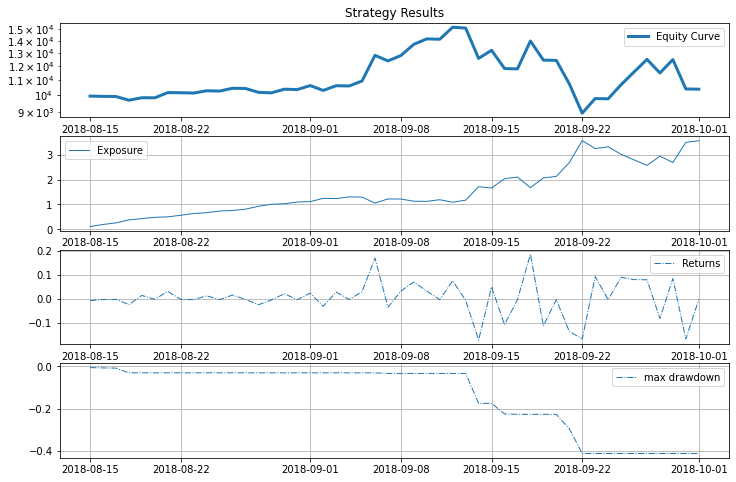

In [8]:
%%time
start_date = pd.Timestamp(datetime(2018, 8, 14, tzinfo=pytz.UTC))
end_date = pd.Timestamp(datetime(2018, 9, 30, tzinfo=pytz.UTC))

results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    trading_calendar = get_calendar("Binance"),
    analyze=analyze, 
    handle_data=execute_trade,
    capital_base=10000,
    data_frequency='minute',
    bundle='binance_1m',
#     benchmark_returns=None
)